In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [2]:
application_train = pd.read_csv('D:\\Datasets\\home-credit-default-risk\\application_train.csv')
application_train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [31]:
numerical_cols = [col for col in application_train.columns if (str(application_train[col].dtype) == 'int64' or str(application_train[col].dtype) == 'float64') and ('FLAG' not in col) and ('NOT' not in col) and ('RATING' not in col)]
categorical_cols = [col for col in application_train.columns if str(application_train[col].dtype) == 'object' or col=='TARGET' or 'FLAG' in col or 'NOT' in col or 'RATING' in col]

In [4]:
application_train_numerical = application_train[numerical_cols]

In [5]:
application_train_categorical = application_train[categorical_cols]

In [6]:
summary_stats_numerical = application_train_numerical.describe()

In [7]:
summary_stats_categorical = application_train_categorical.describe()

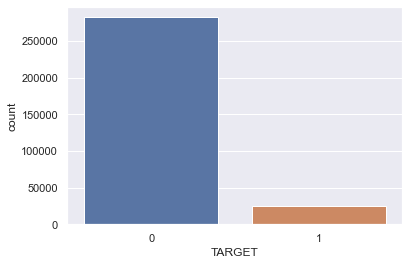

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=application_train, x='TARGET')
plt.show()

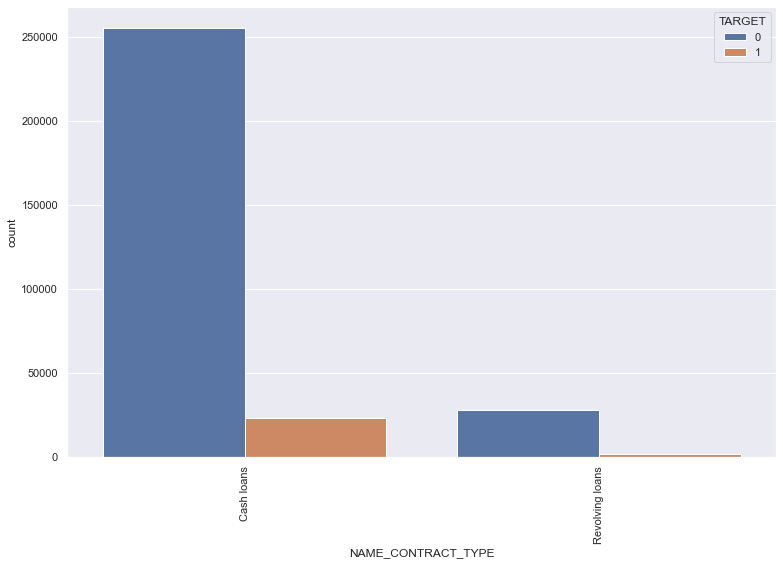

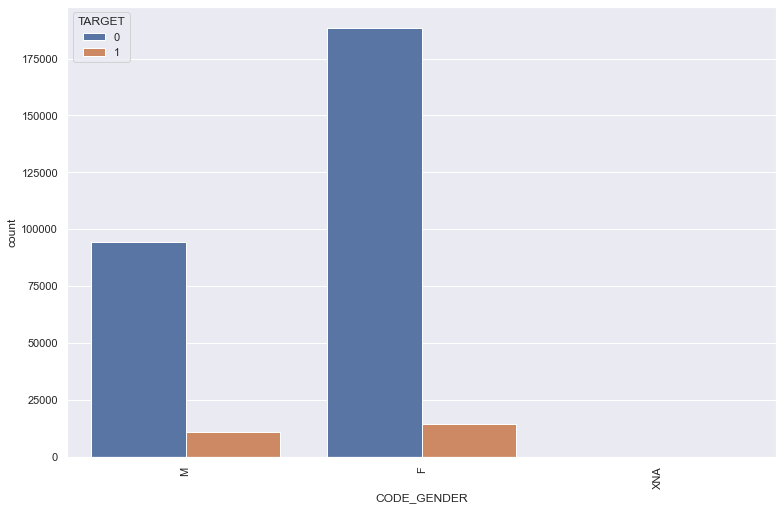

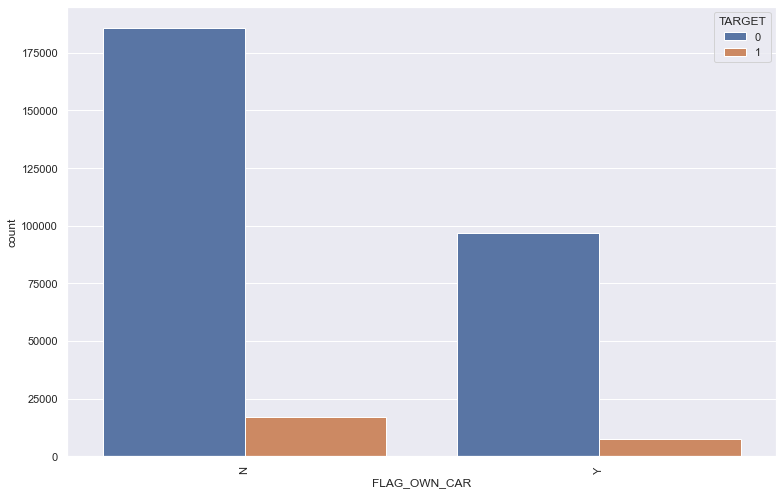

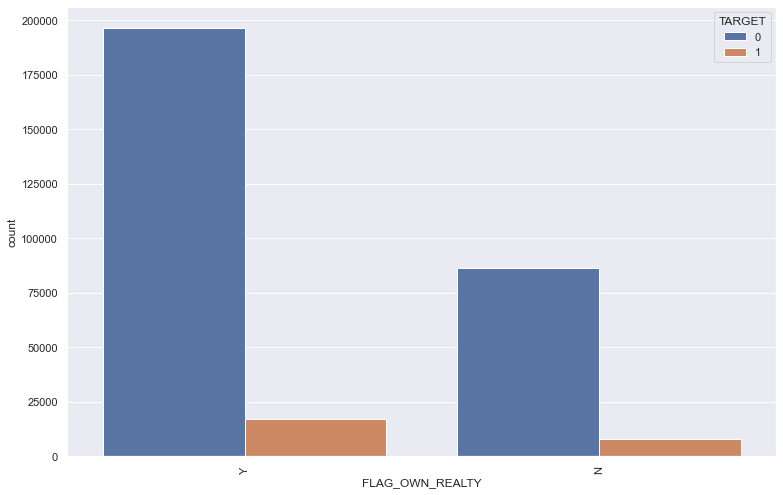

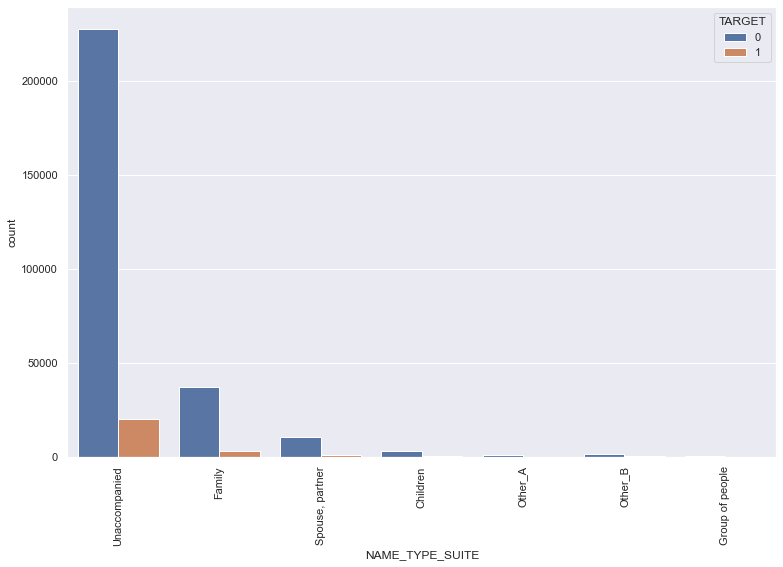

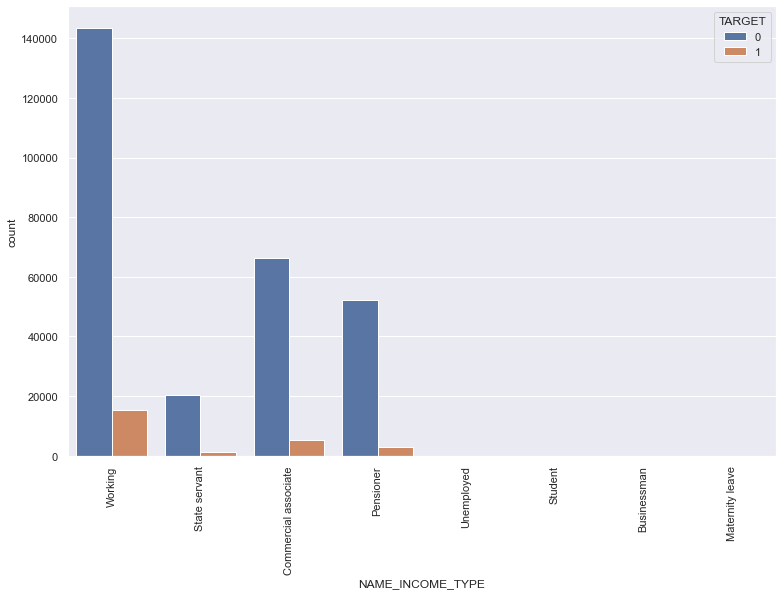

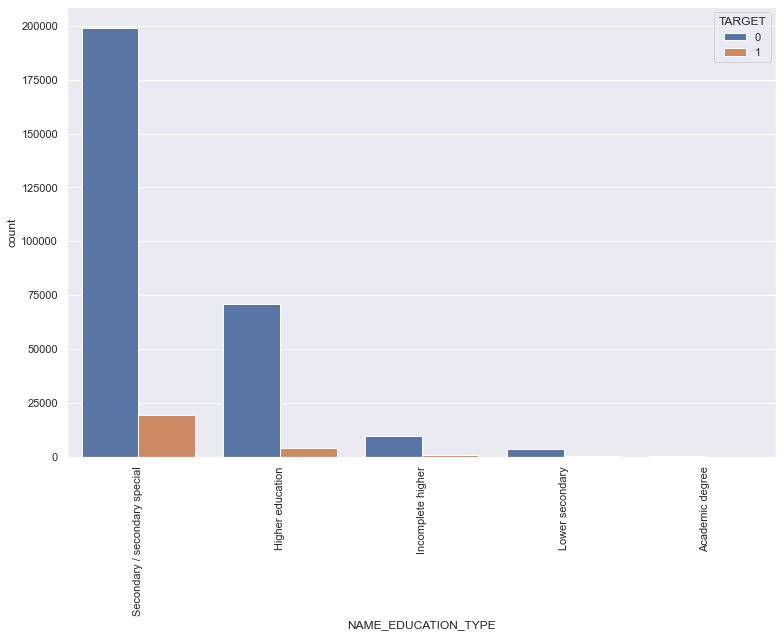

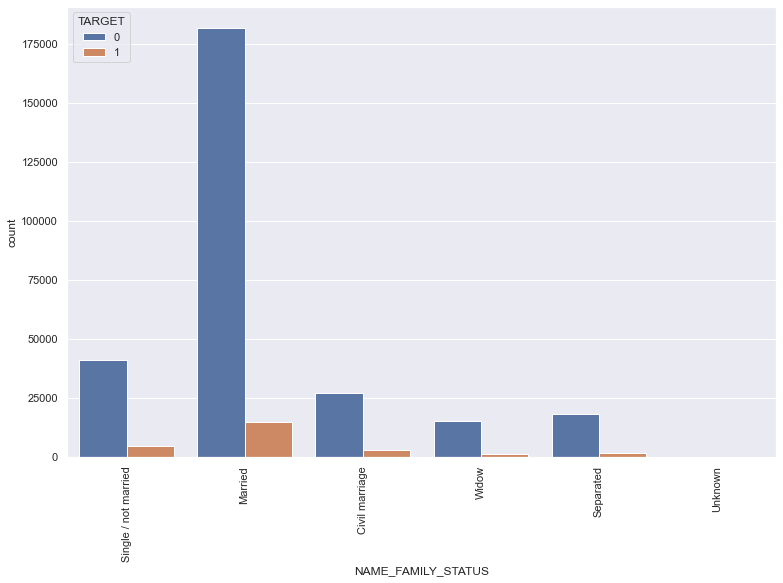

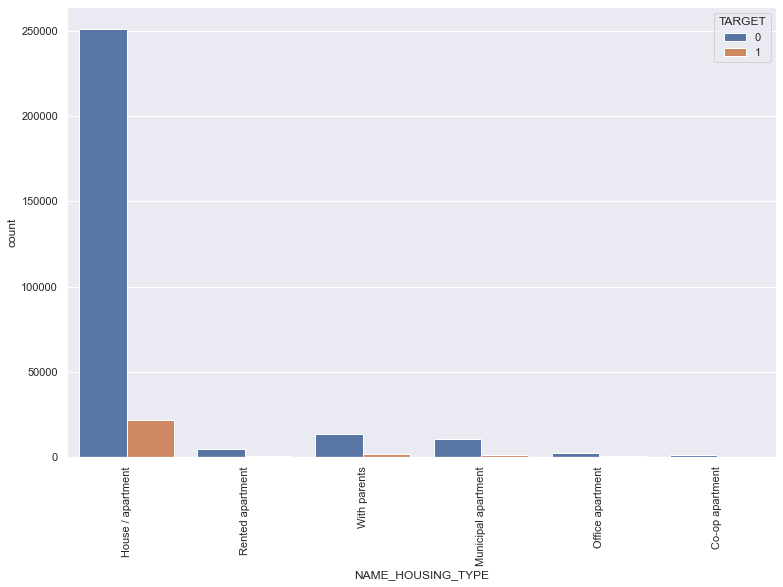

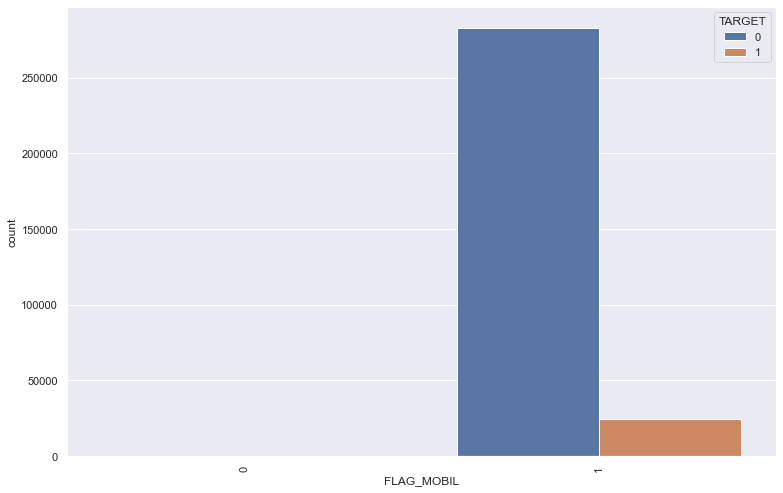

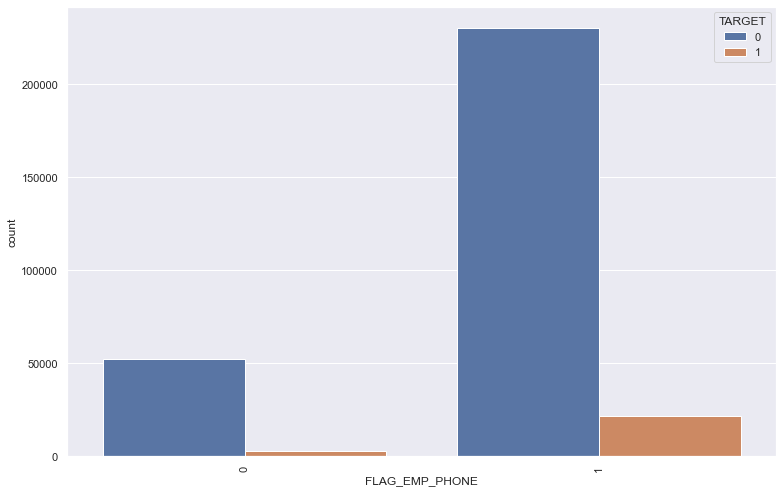

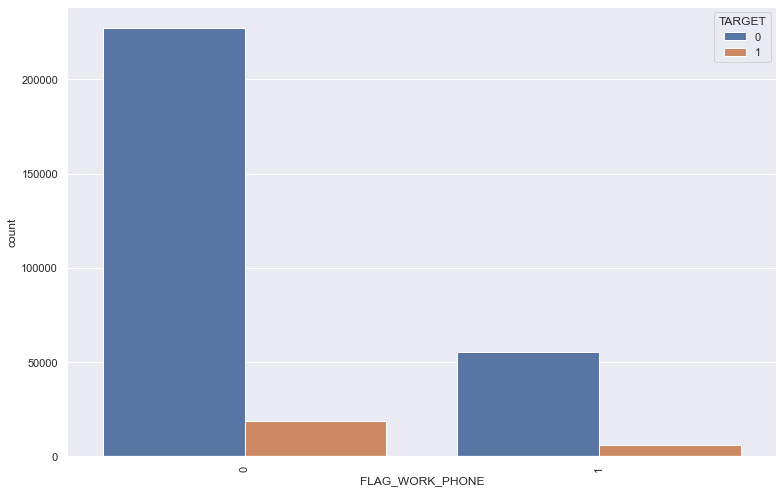

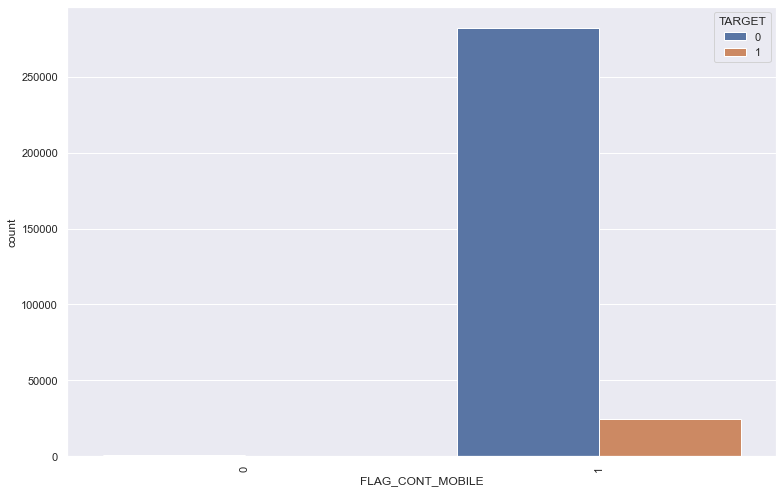

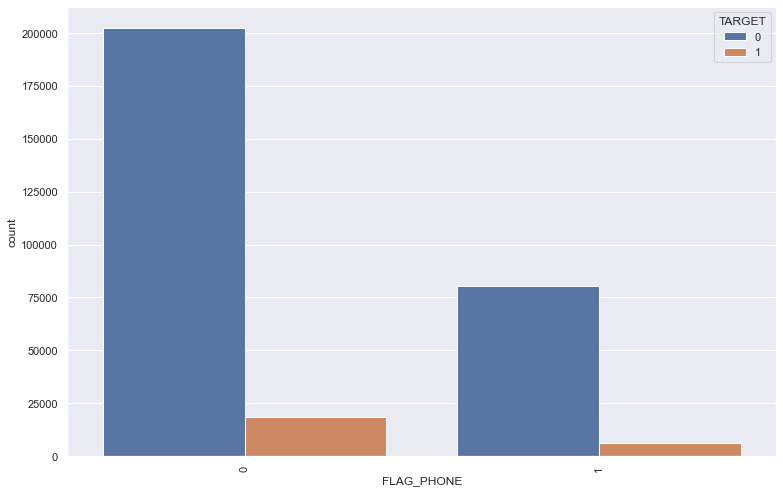

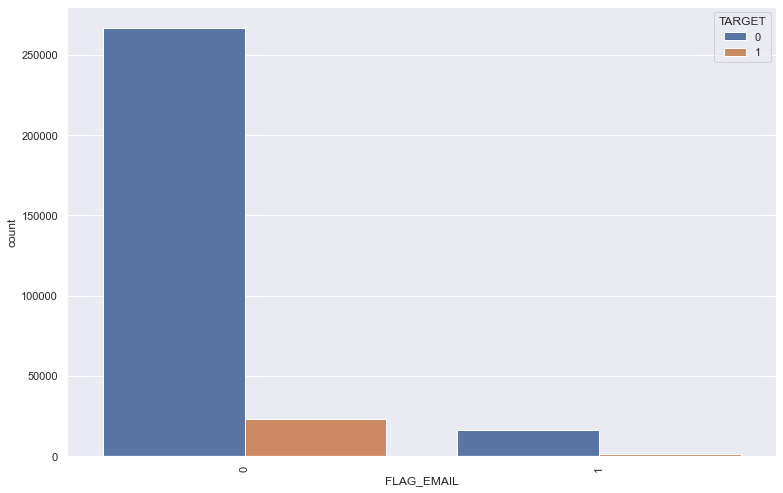

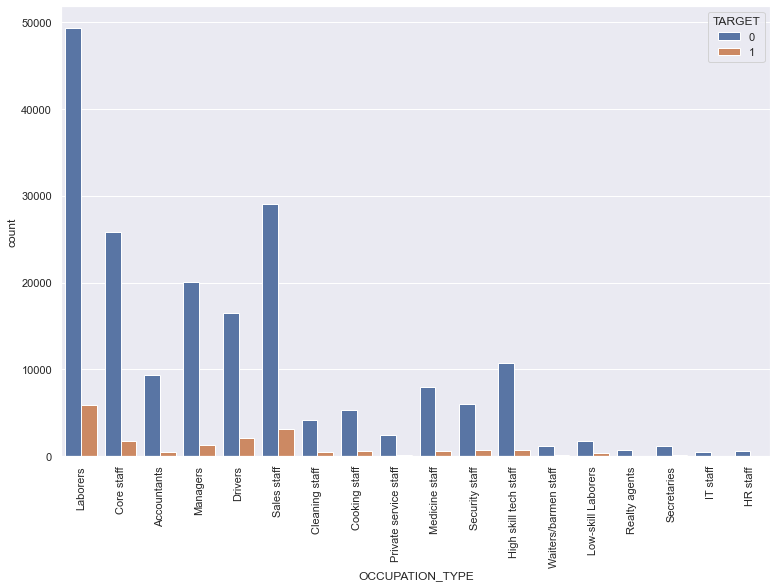

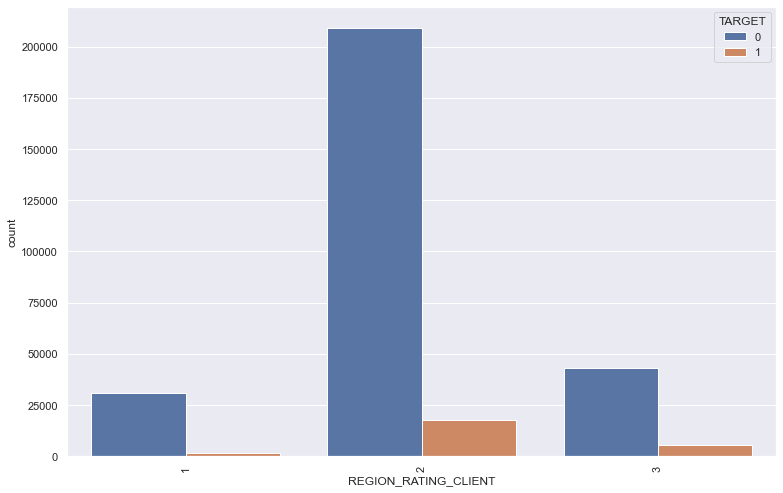

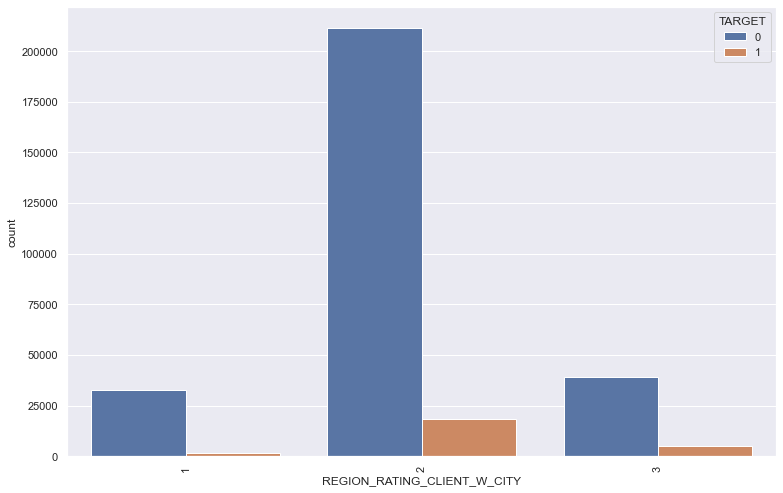

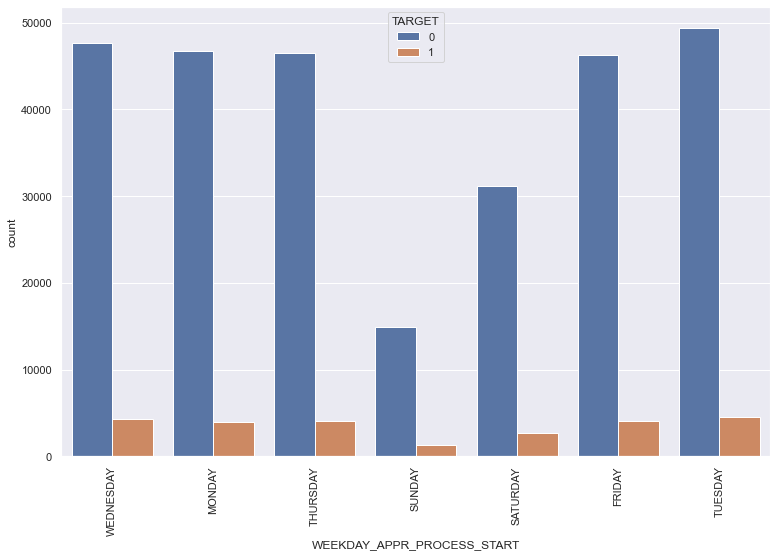

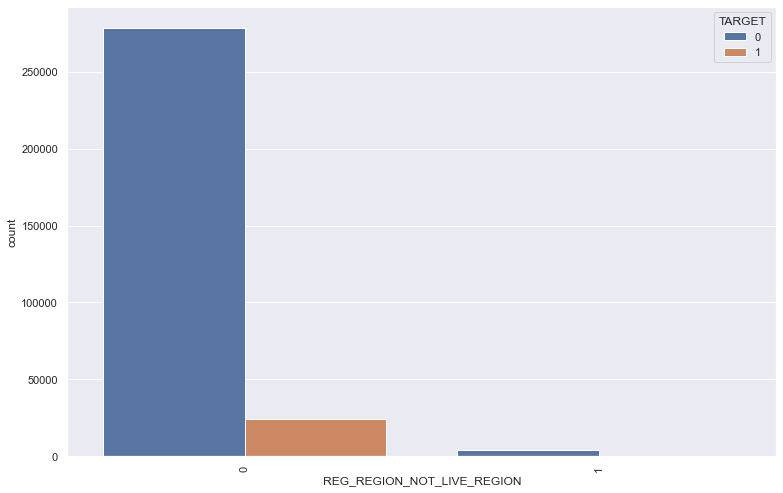

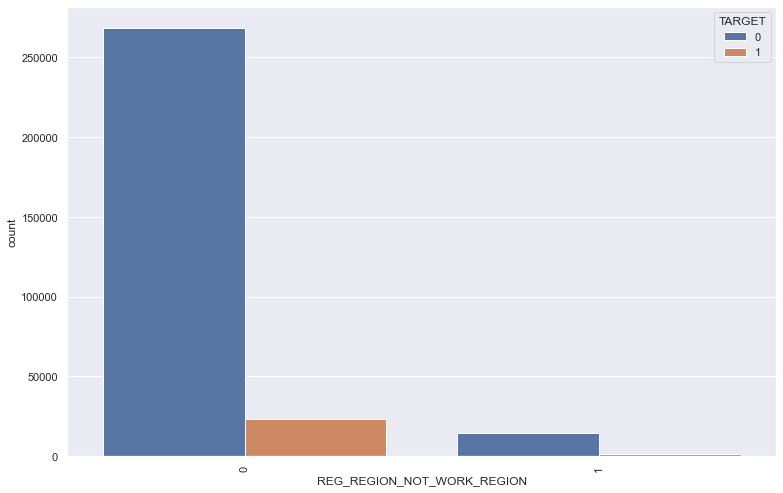

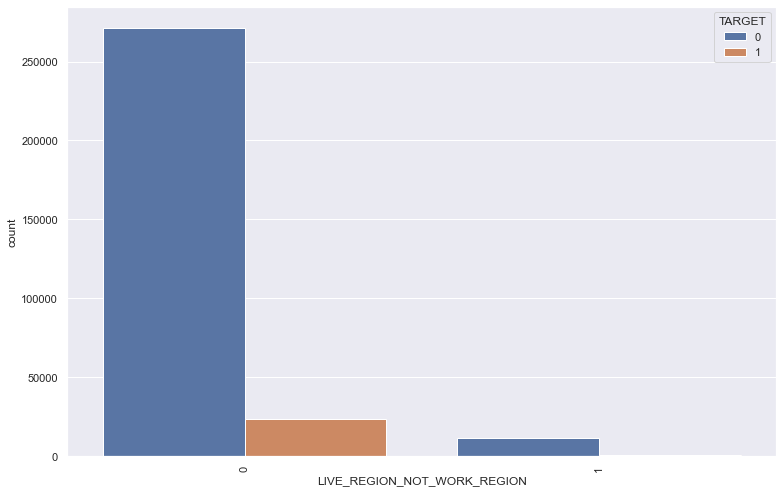

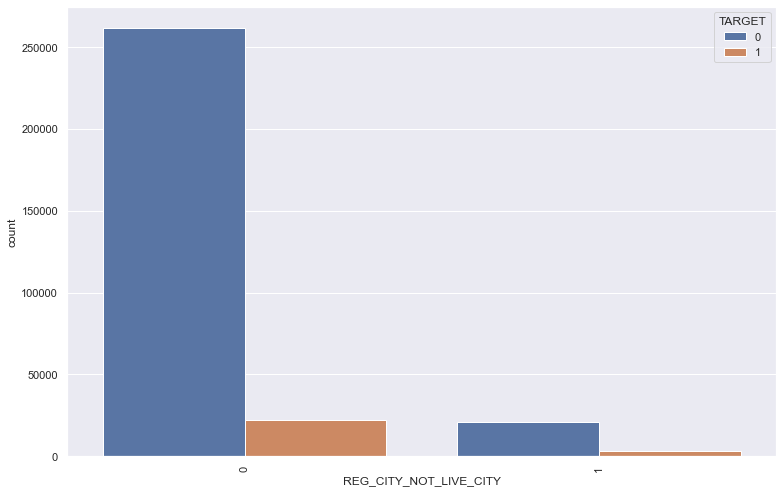

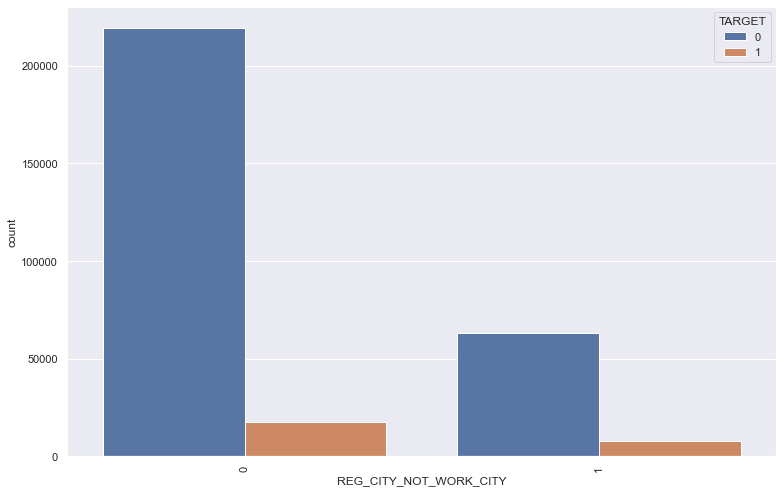

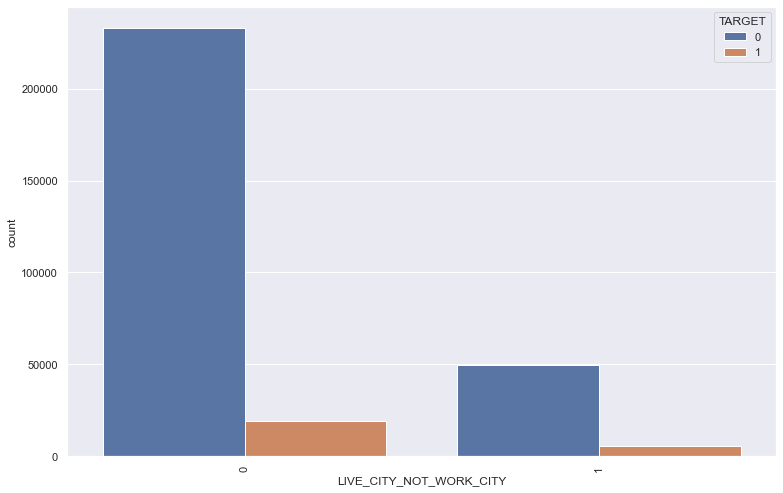

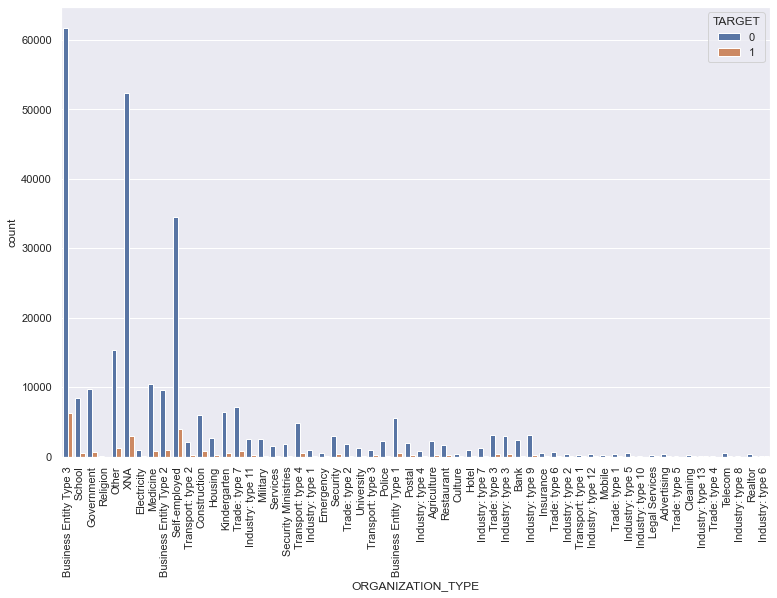

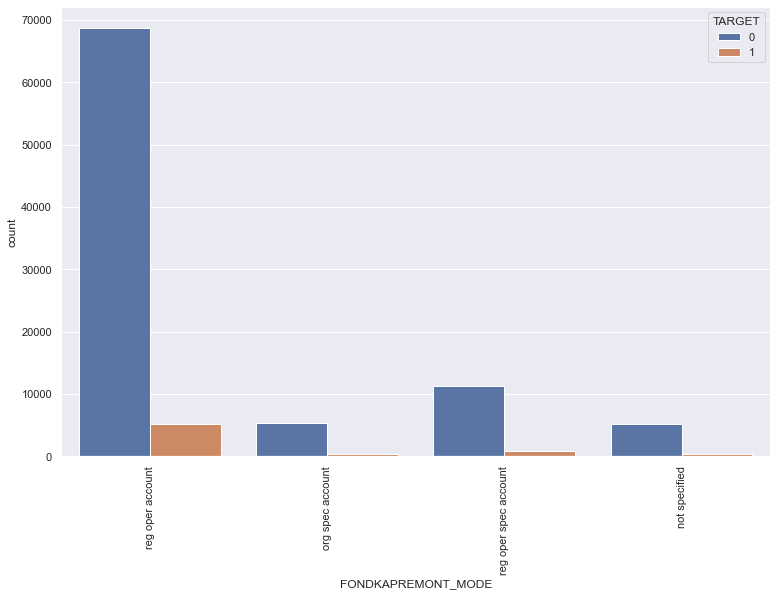

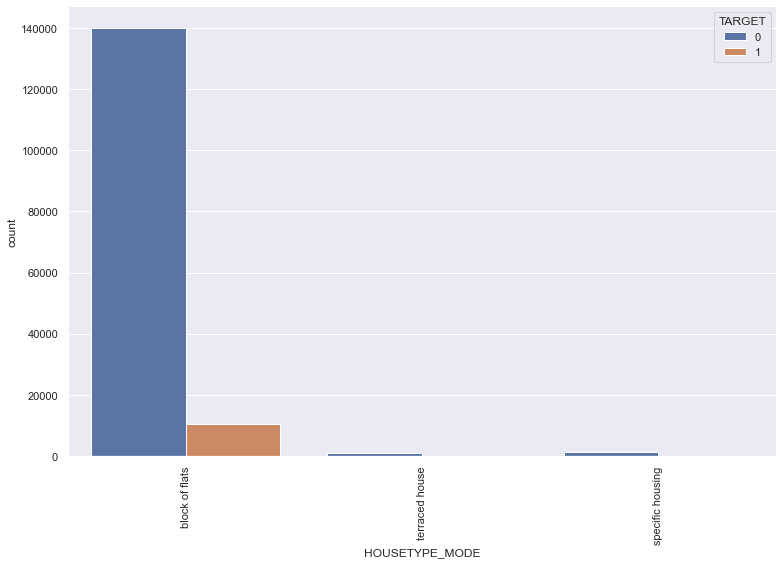

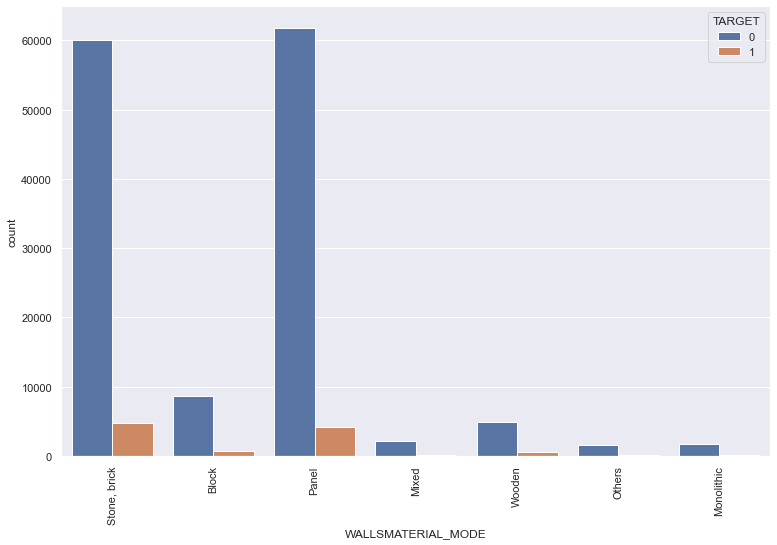

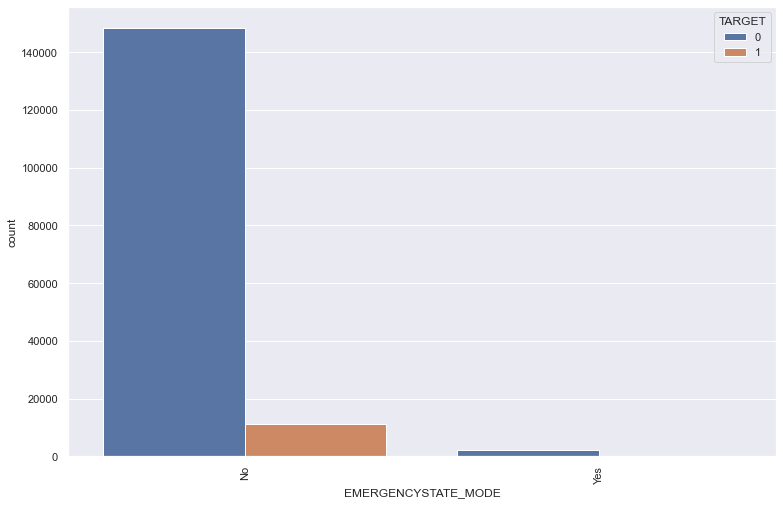

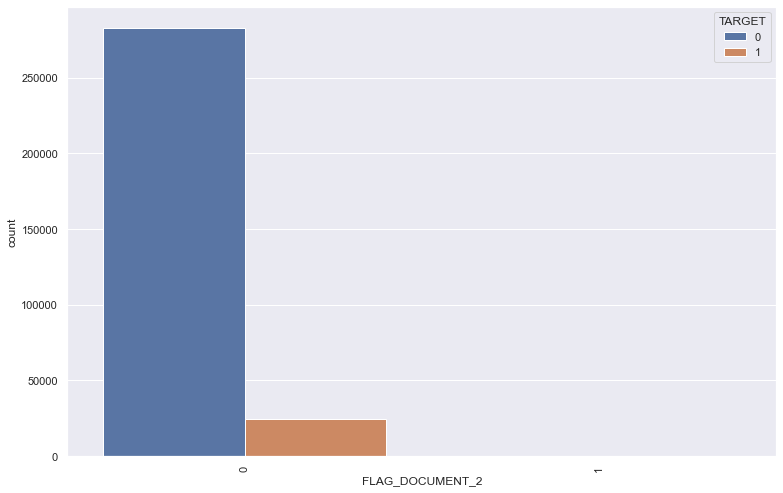

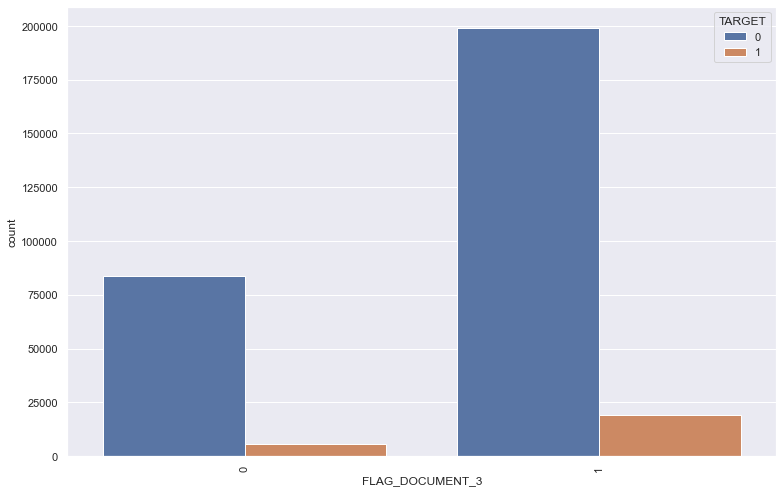

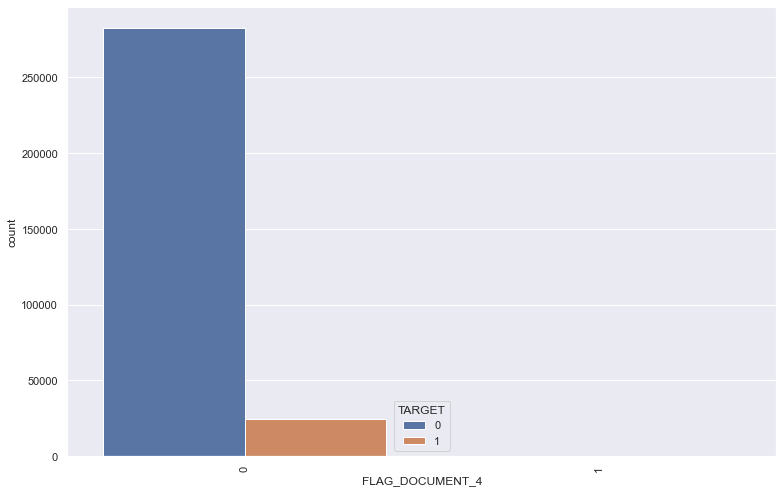

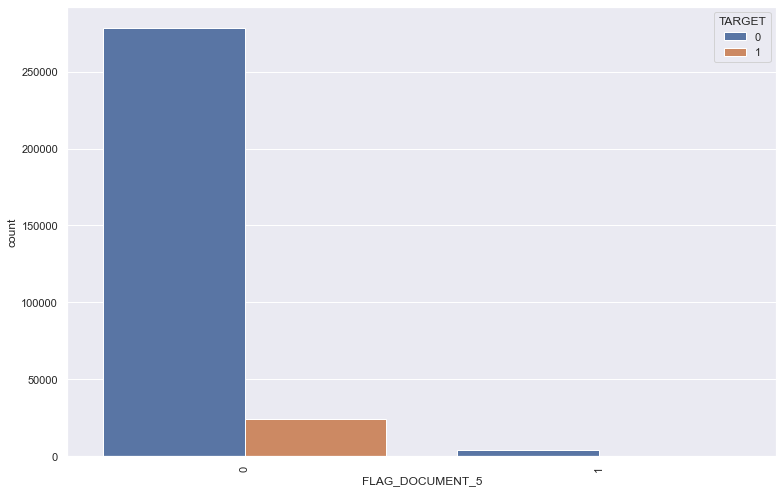

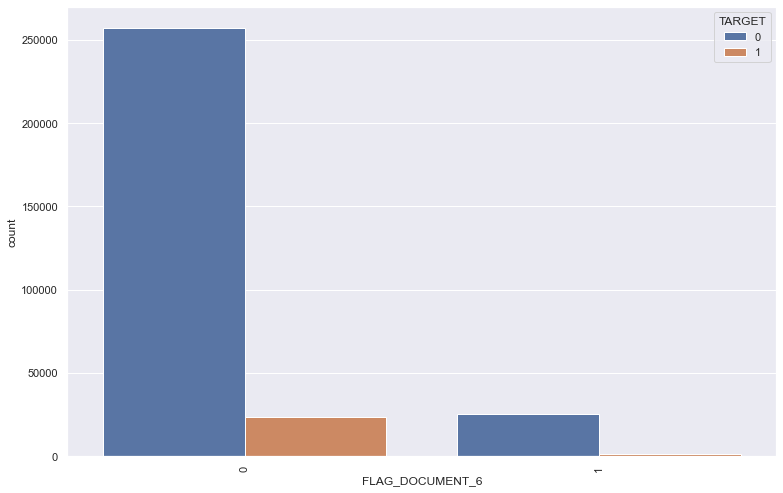

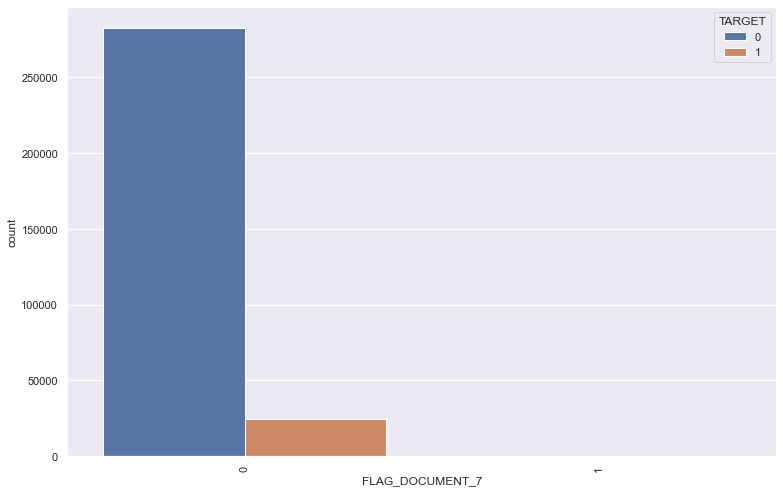

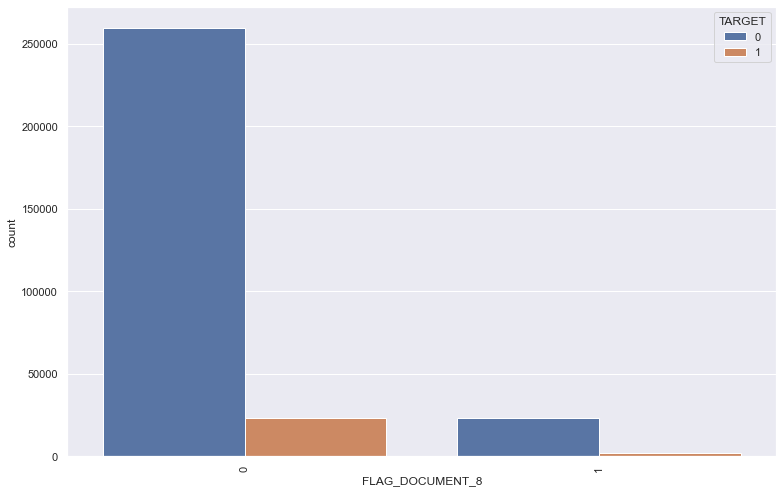

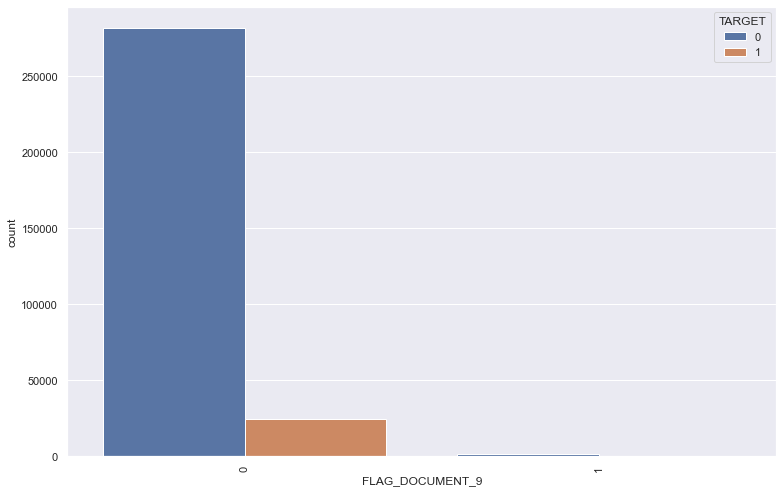

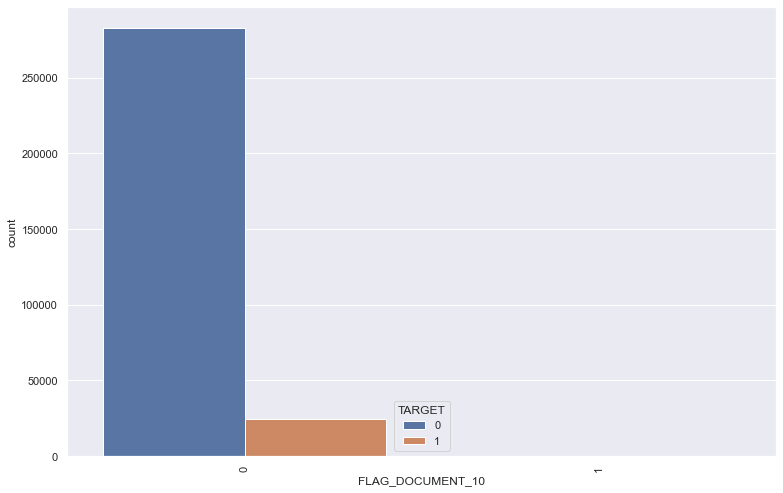

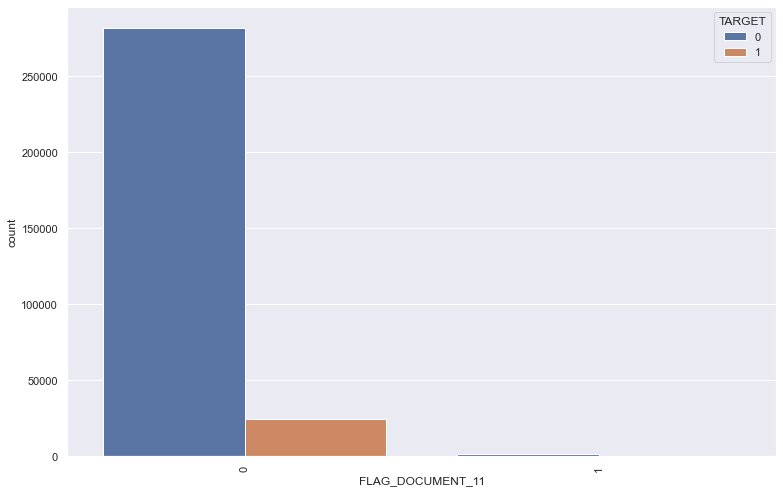

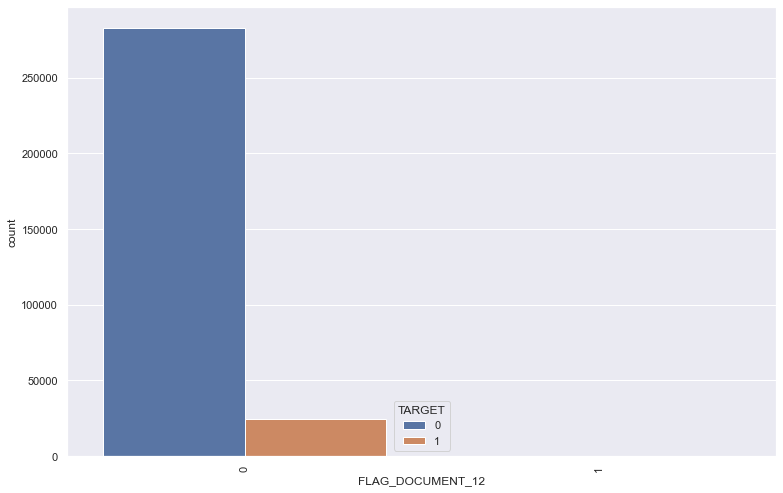

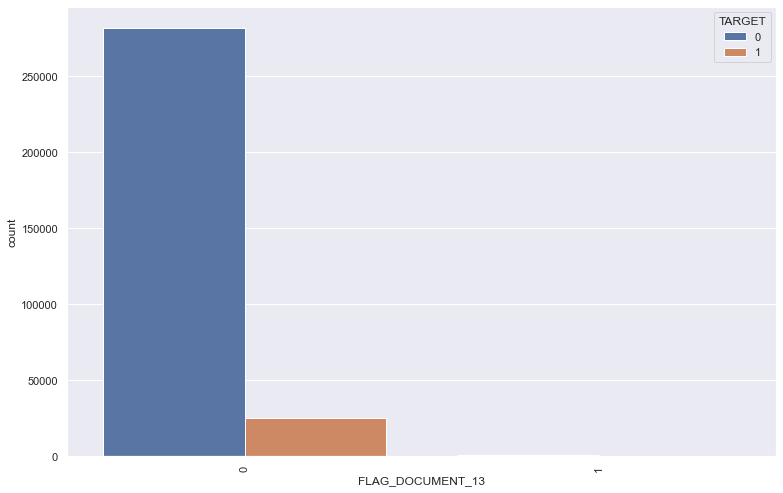

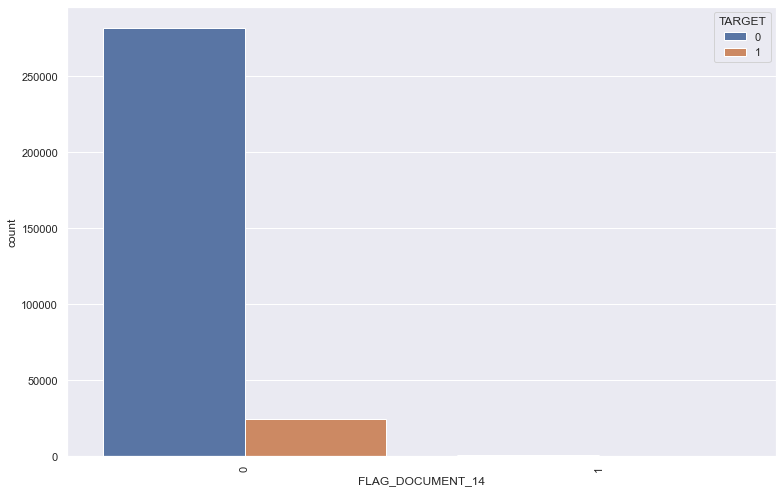

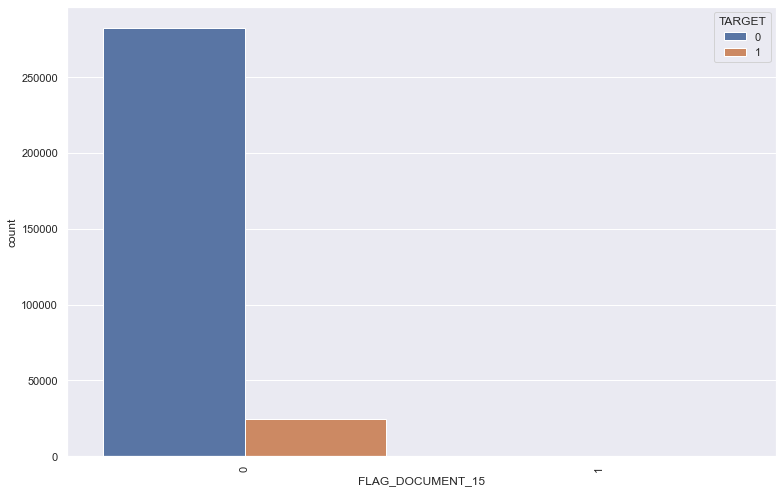

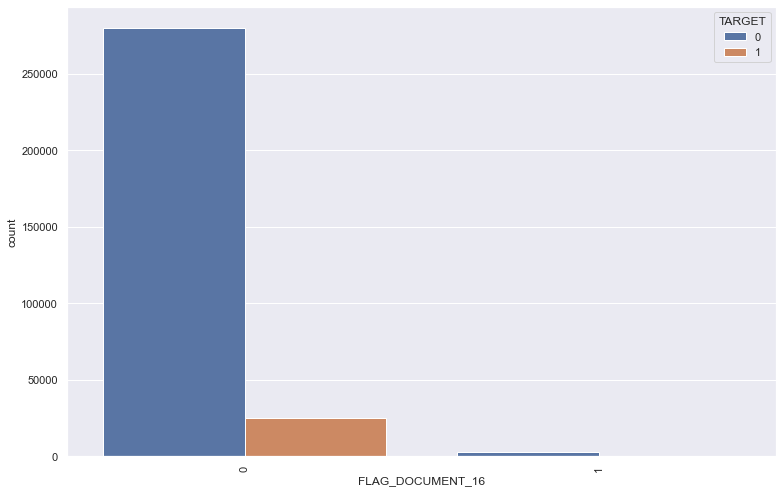

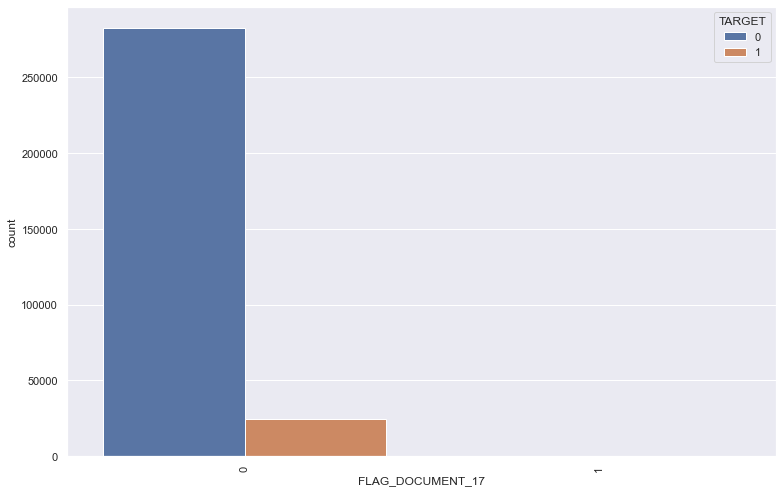

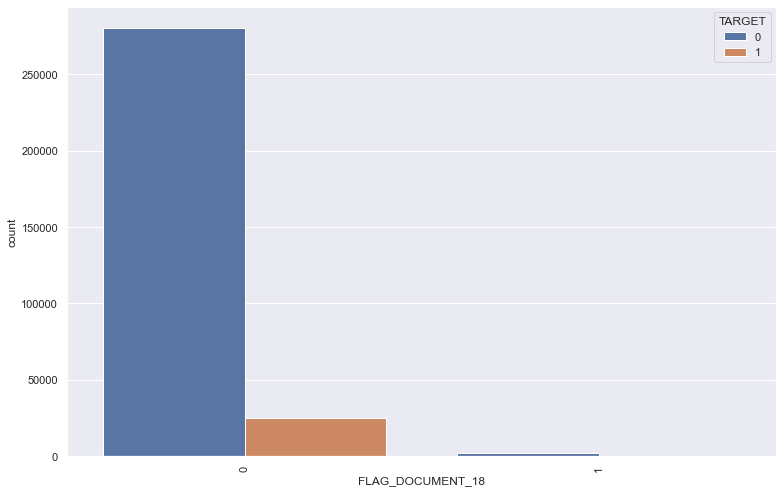

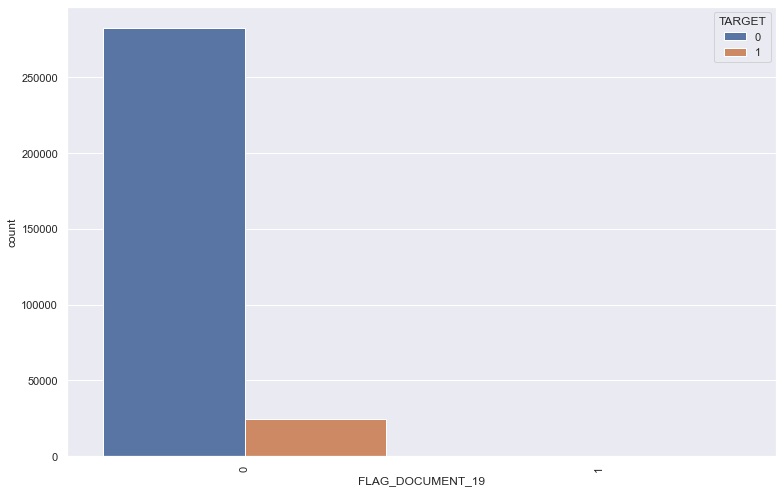

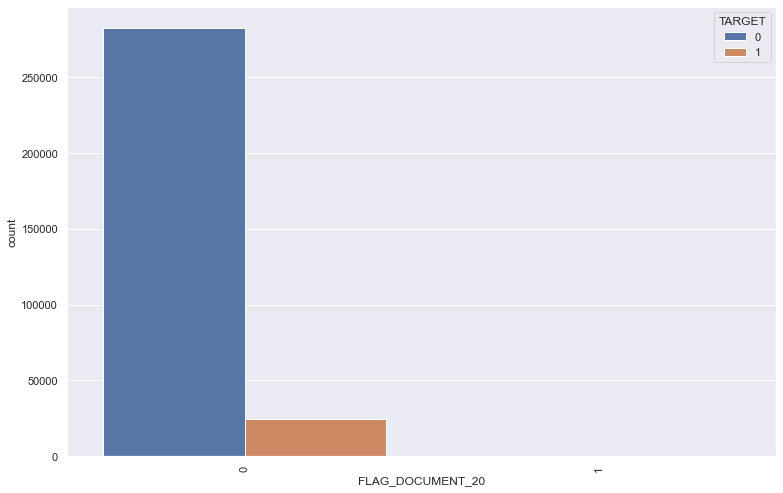

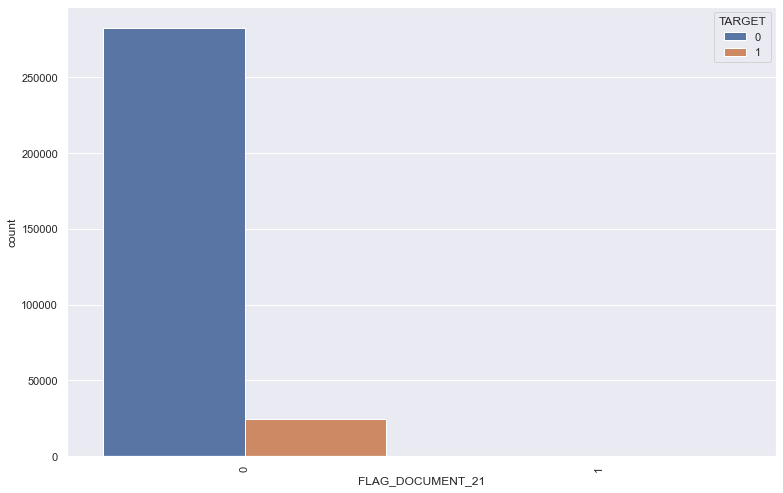

In [9]:
for col in application_train_categorical.columns:
    if col == 'TARGET':
        continue
    sns.set(rc={'figure.figsize':(12.7,8.27)})
    sns.countplot(data=application_train_categorical, x=col, hue='TARGET')
    plt.xticks(rotation=90)
    plt.show()

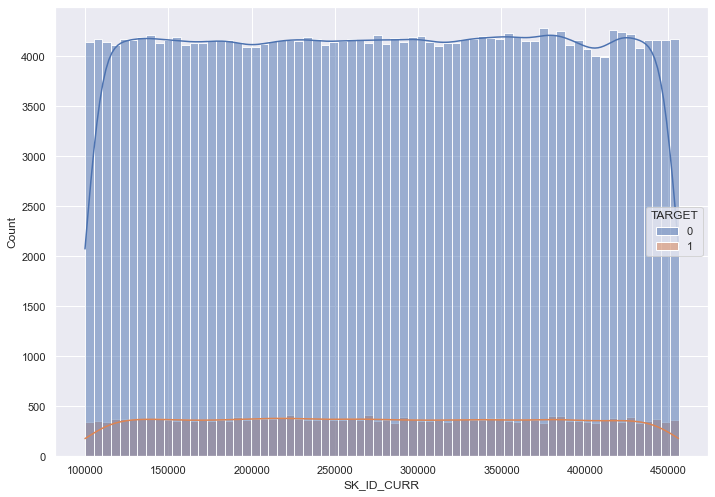

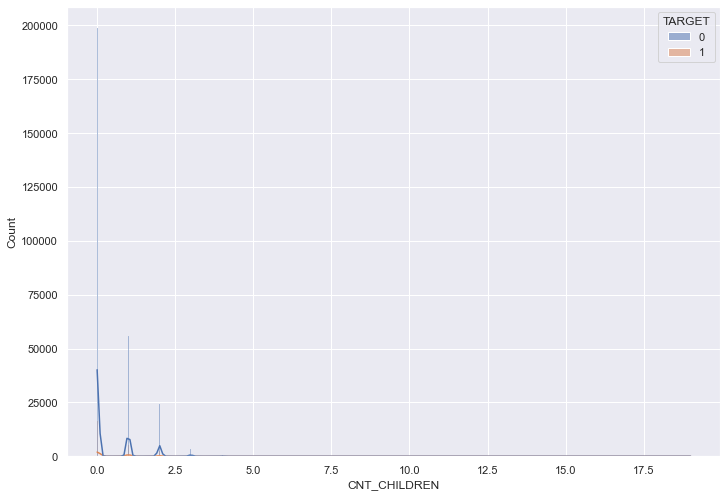

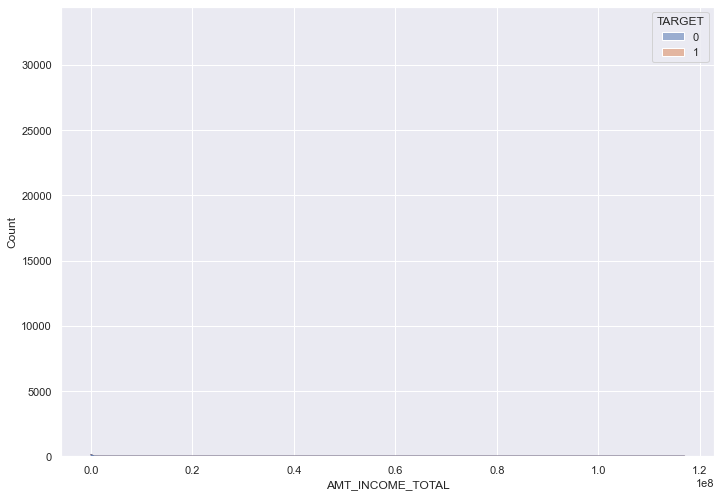

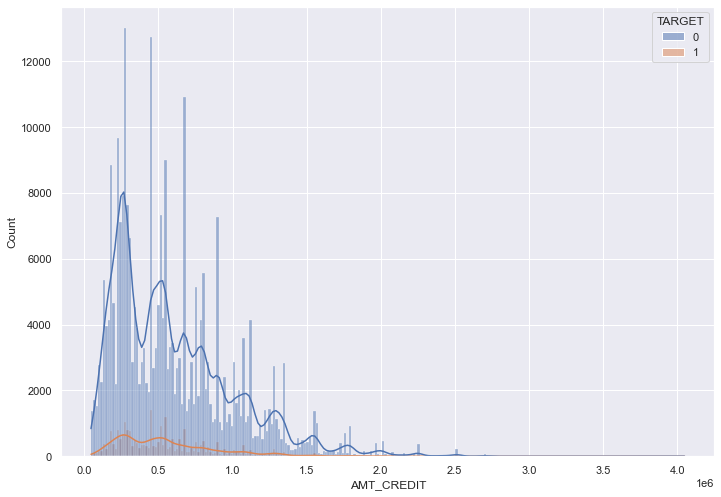

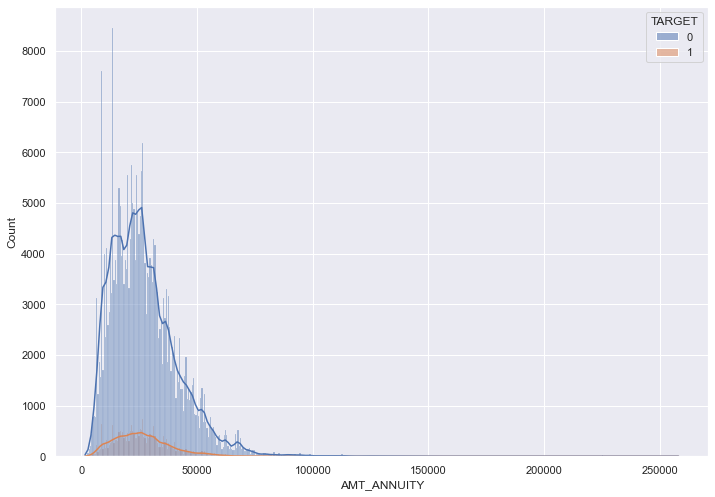

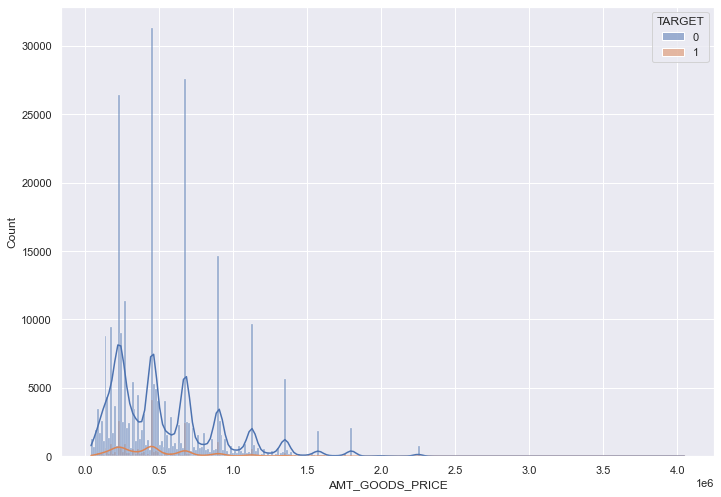

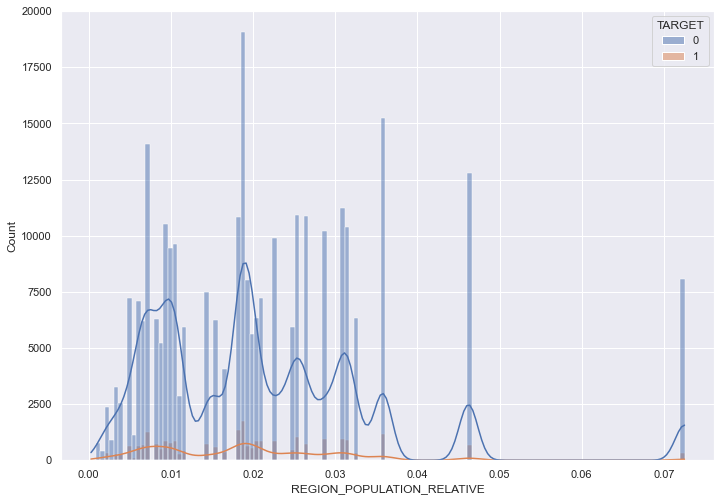

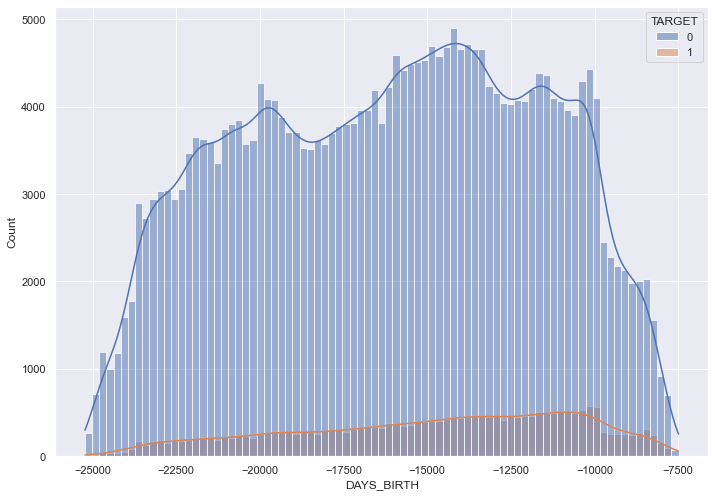

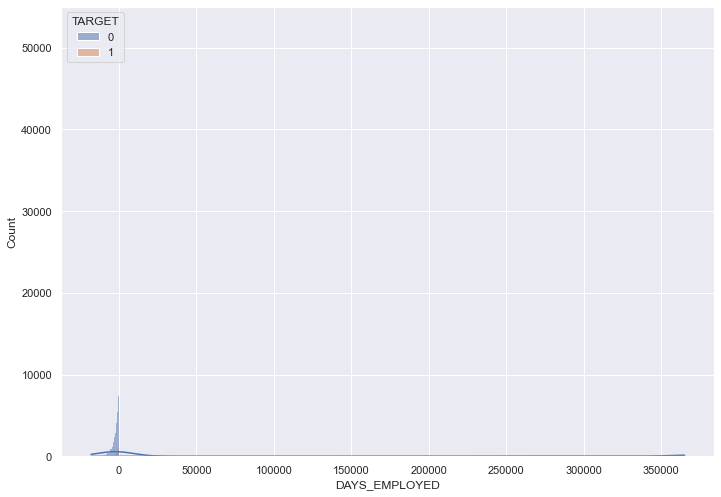

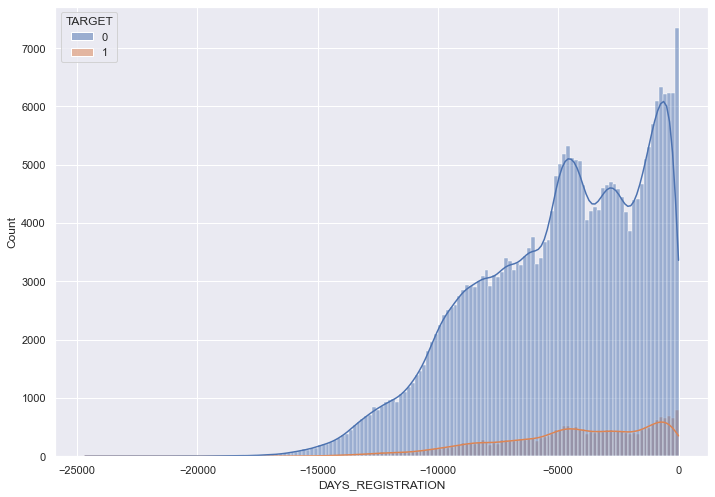

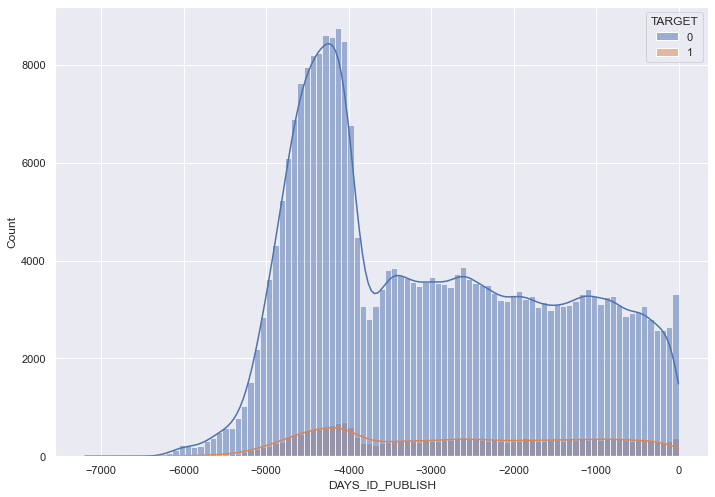

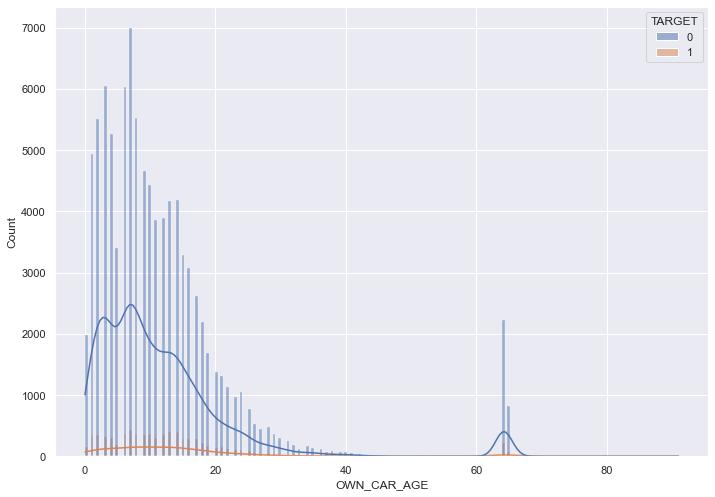

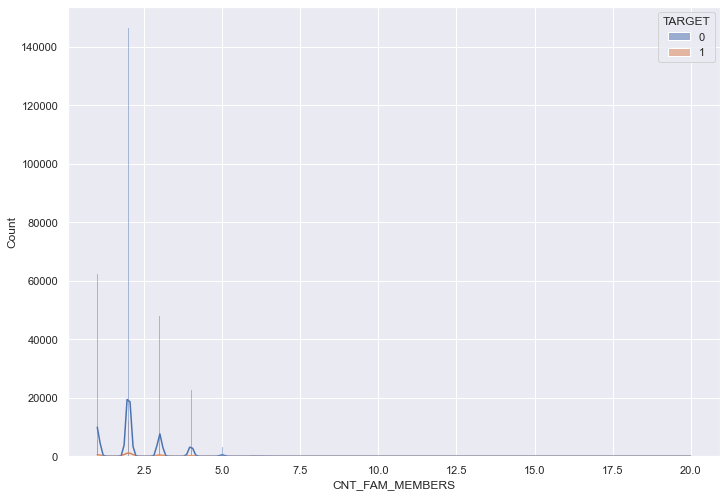

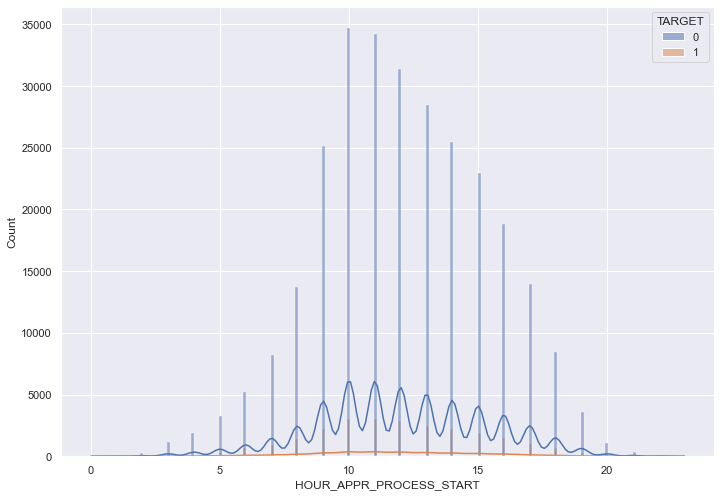

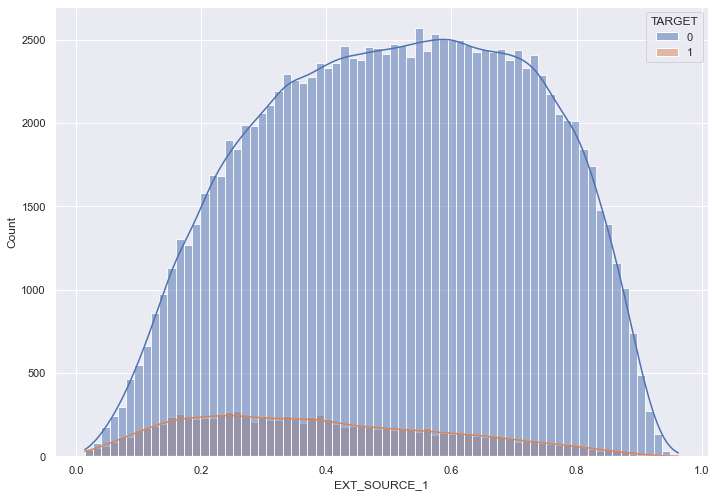

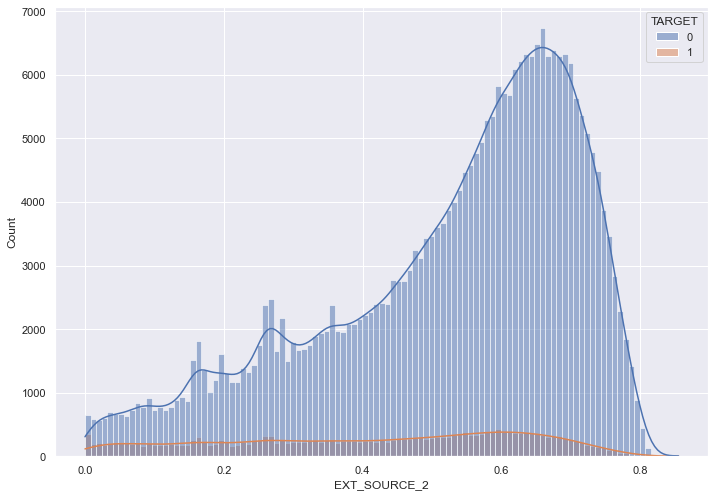

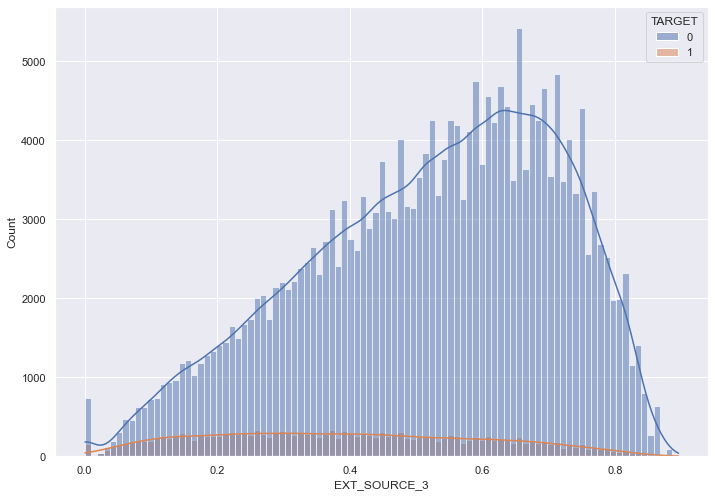

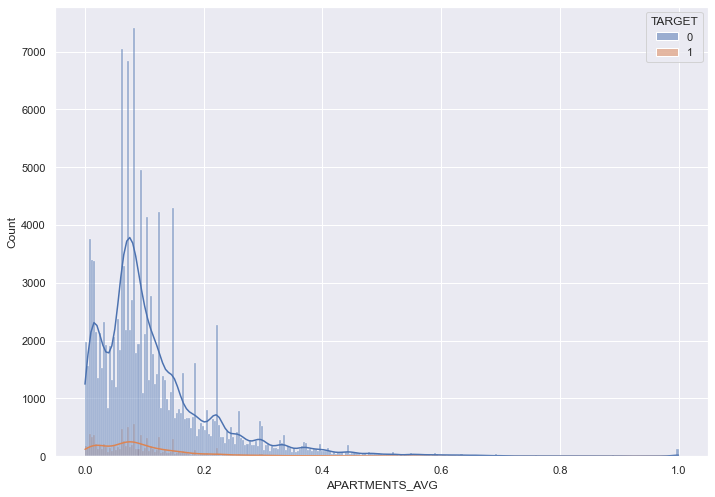

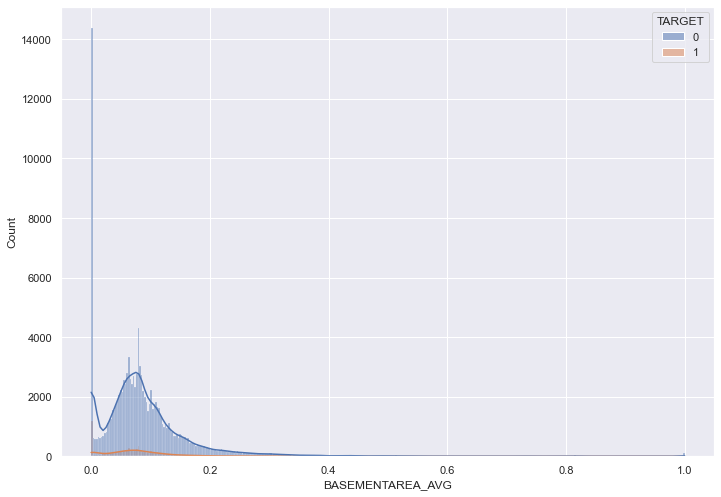

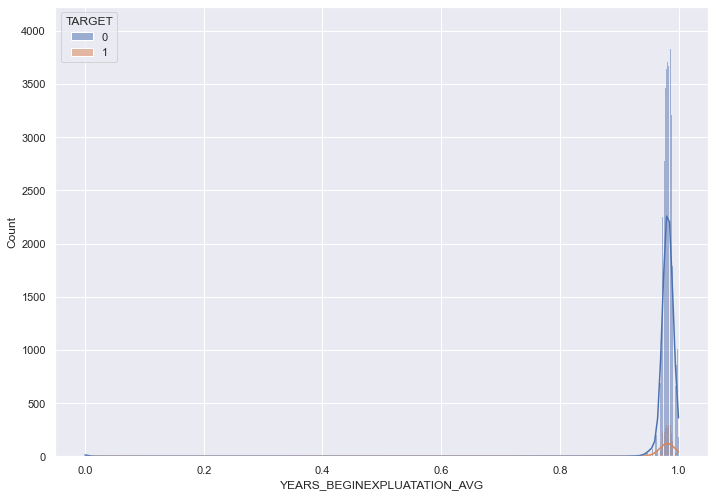

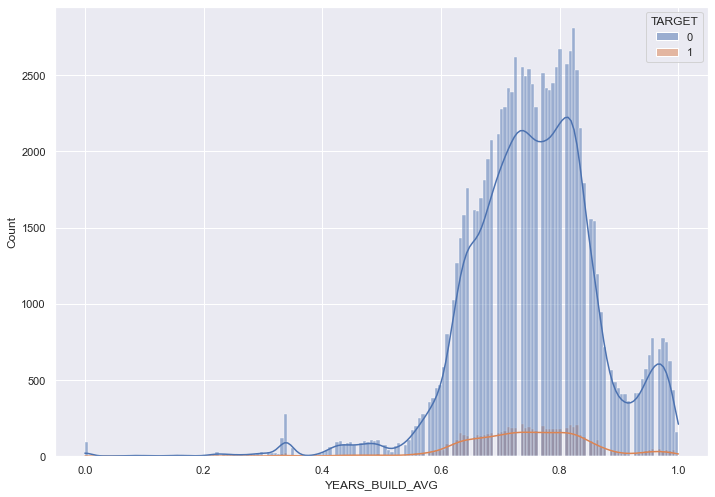

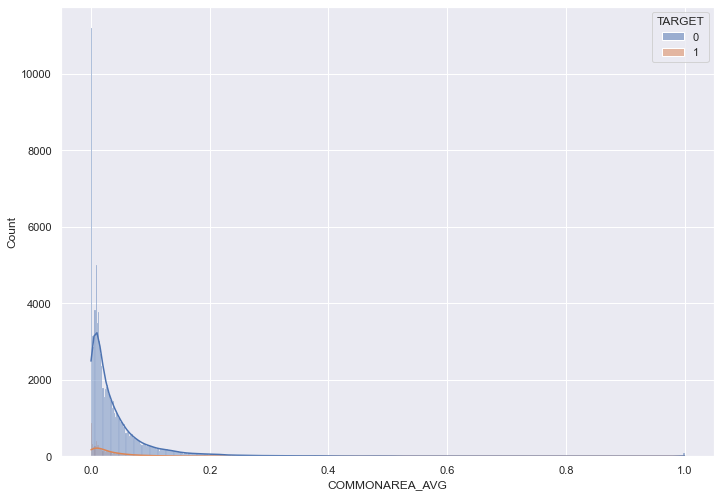

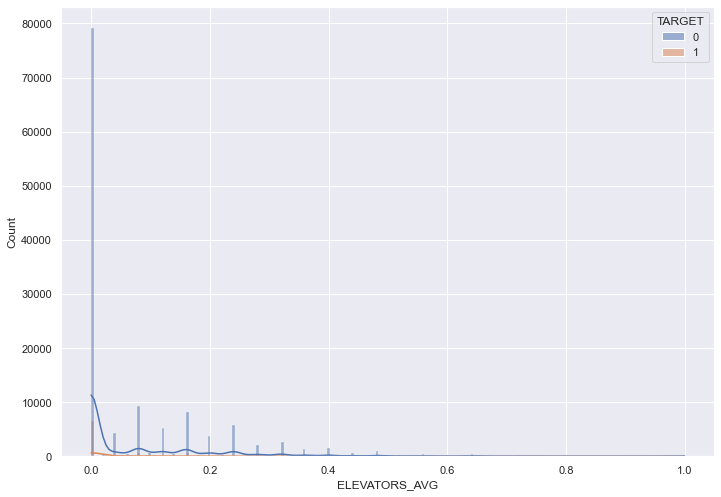

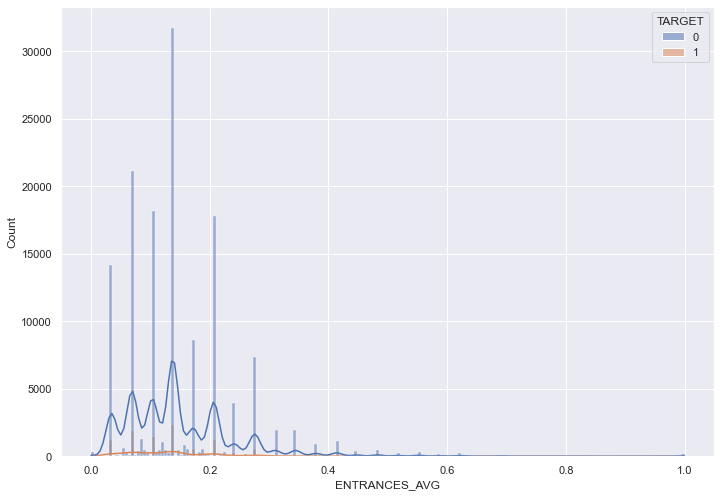

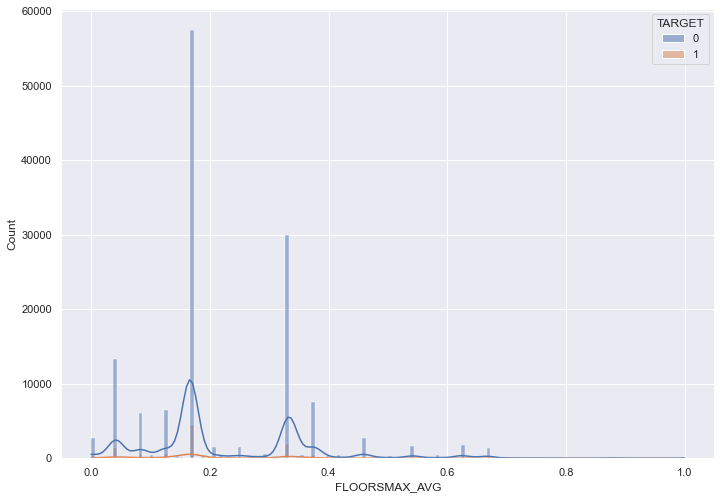

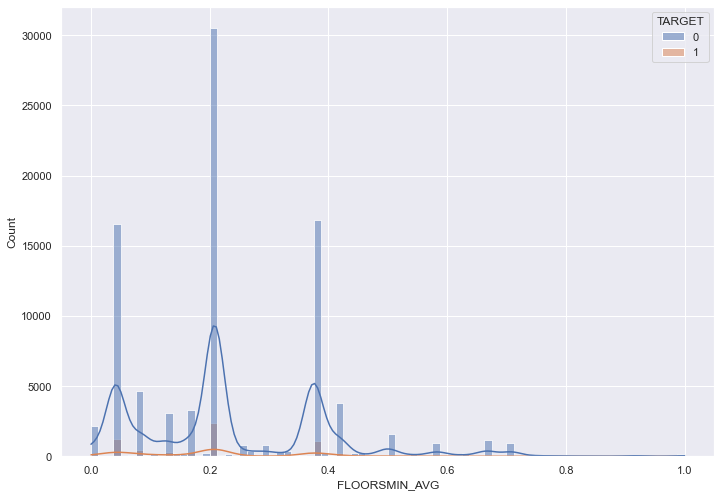

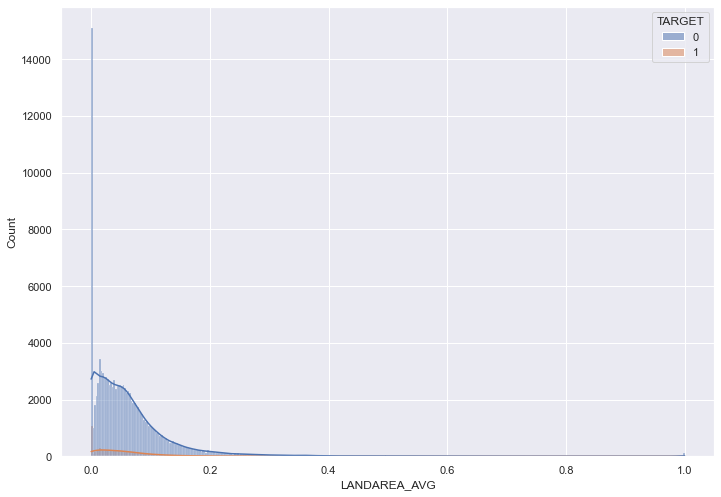

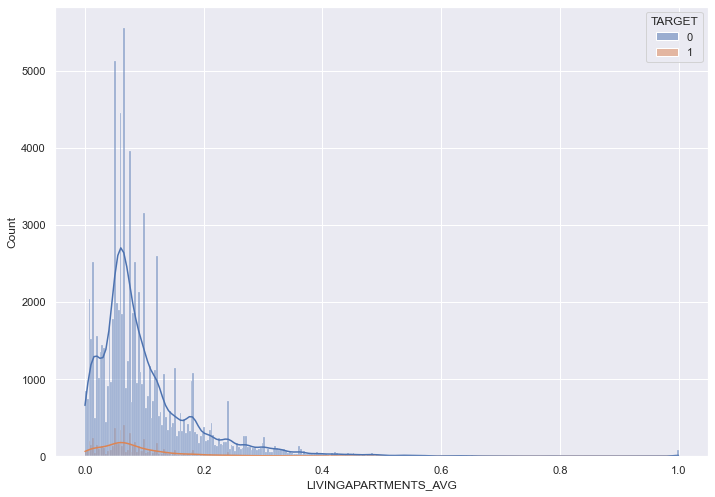

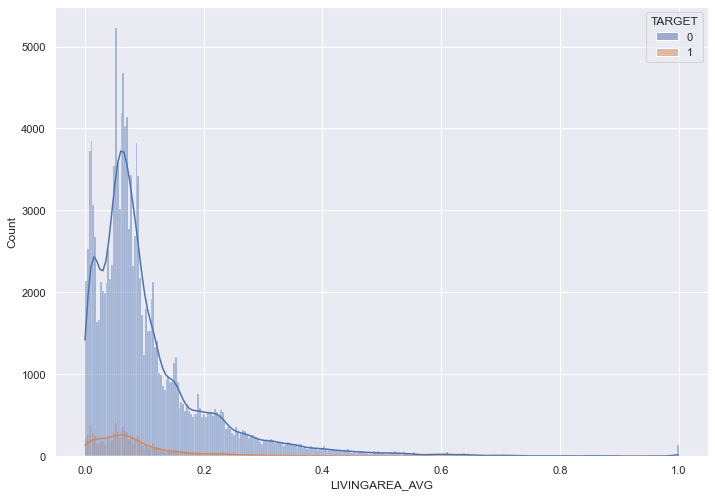

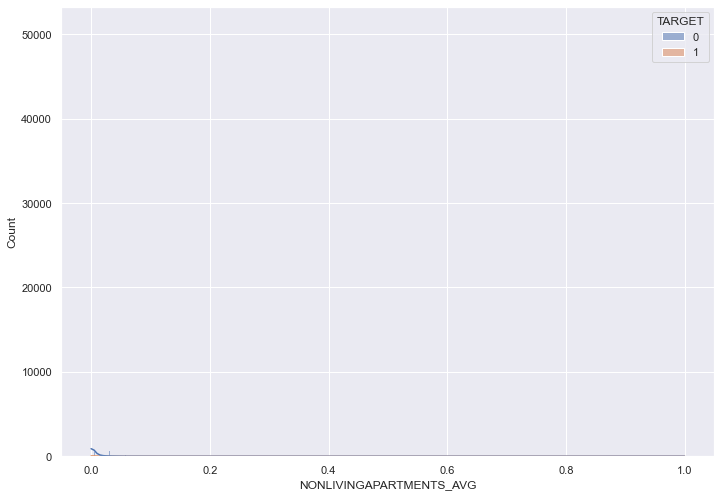

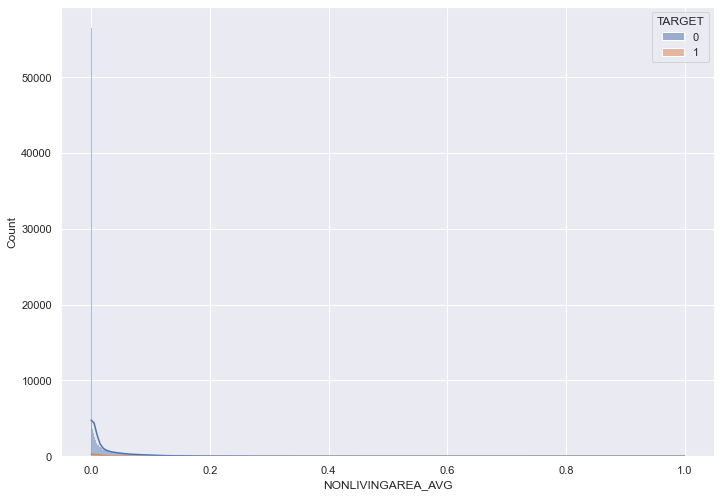

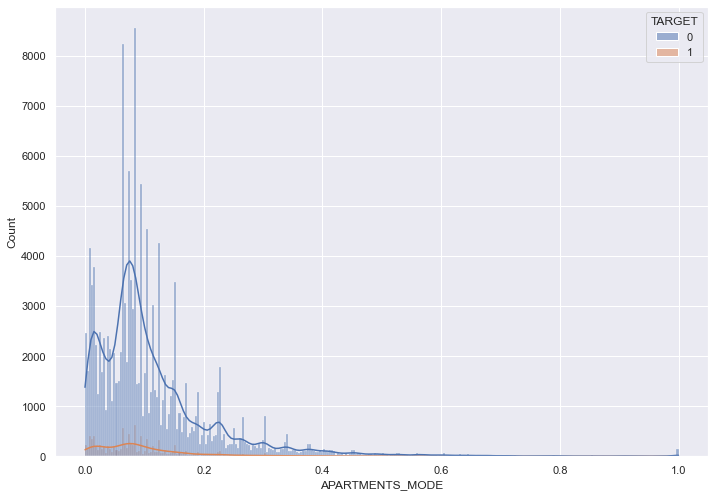

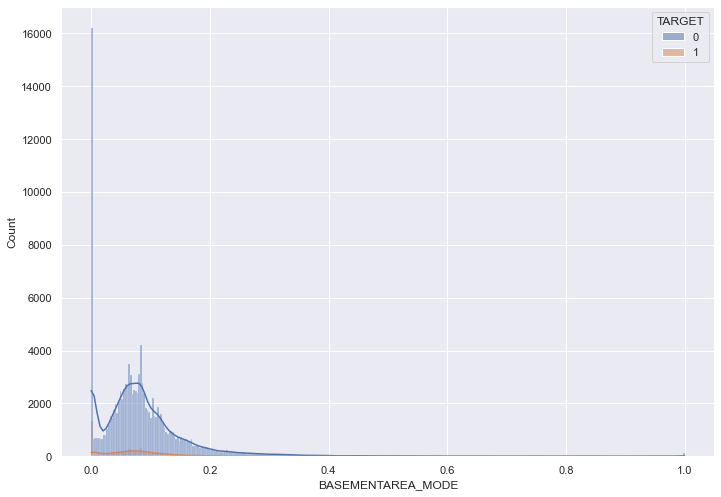

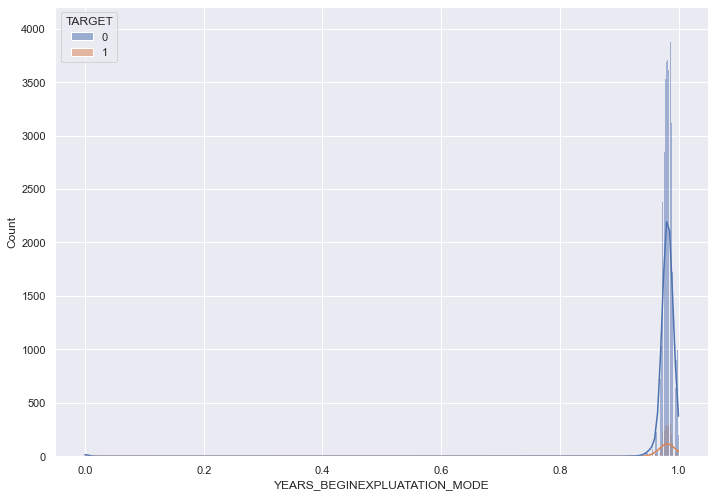

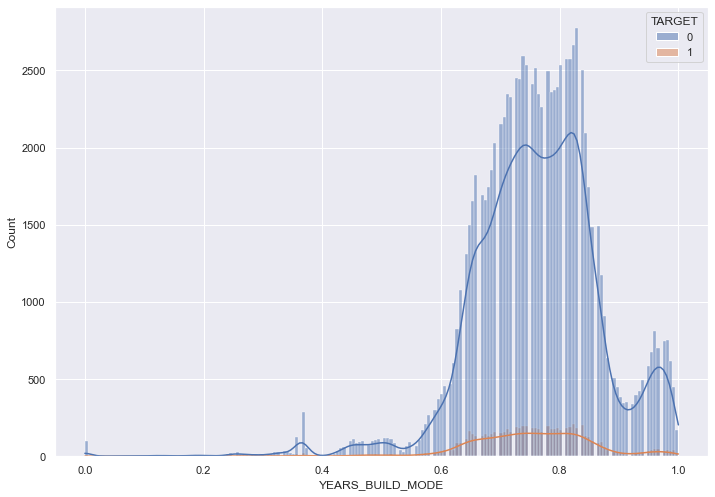

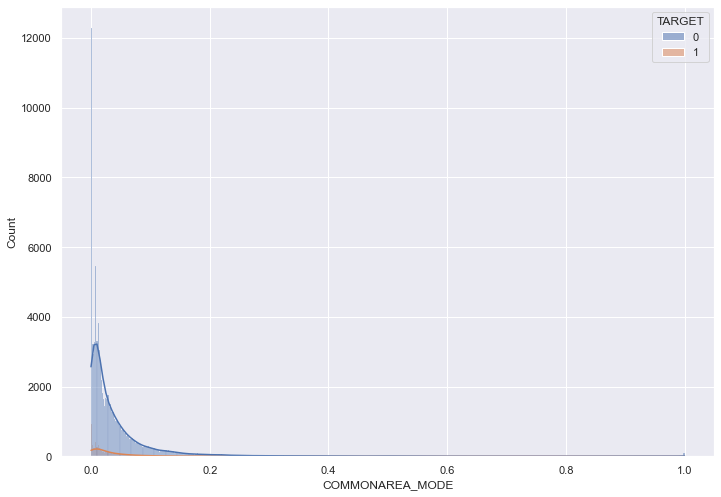

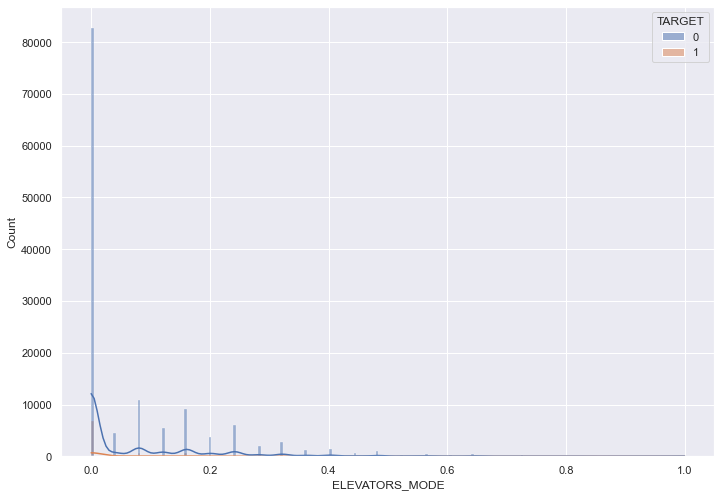

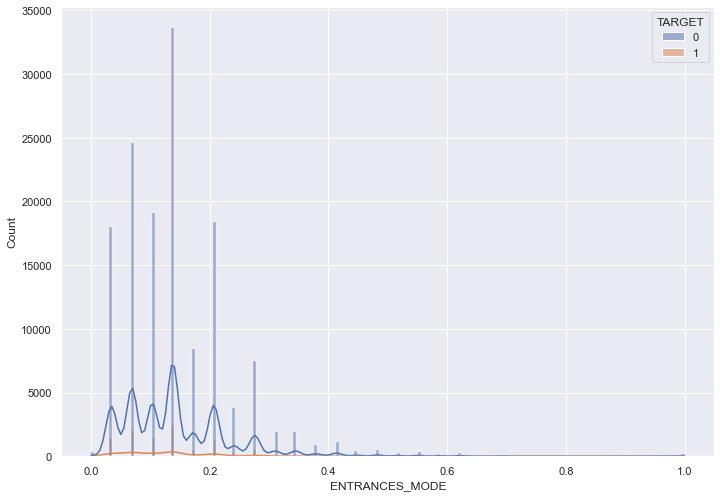

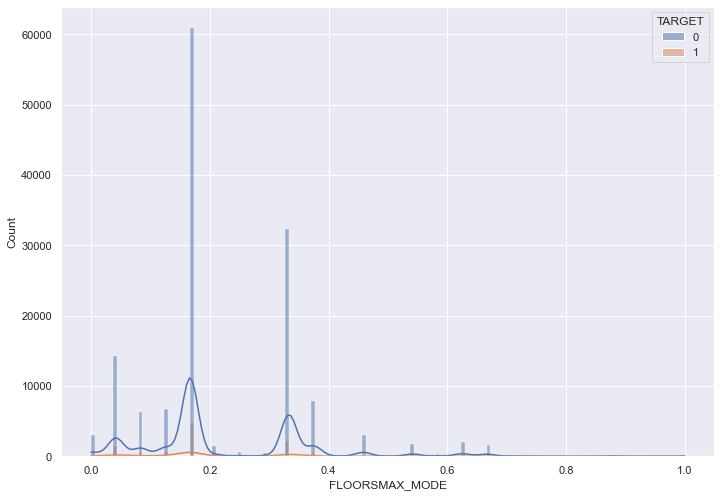

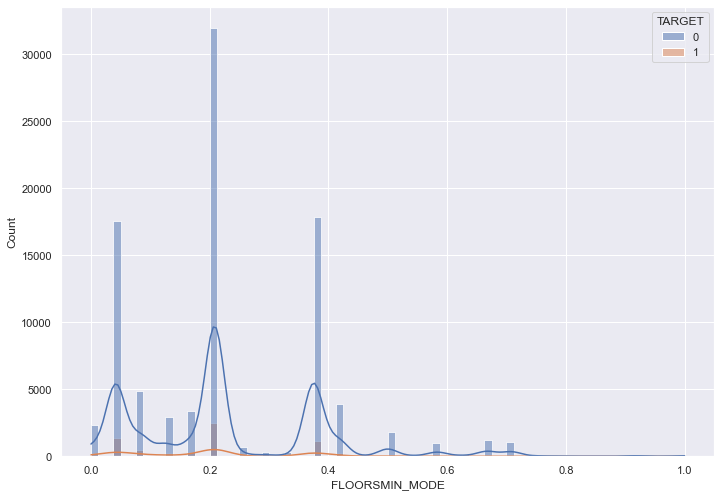

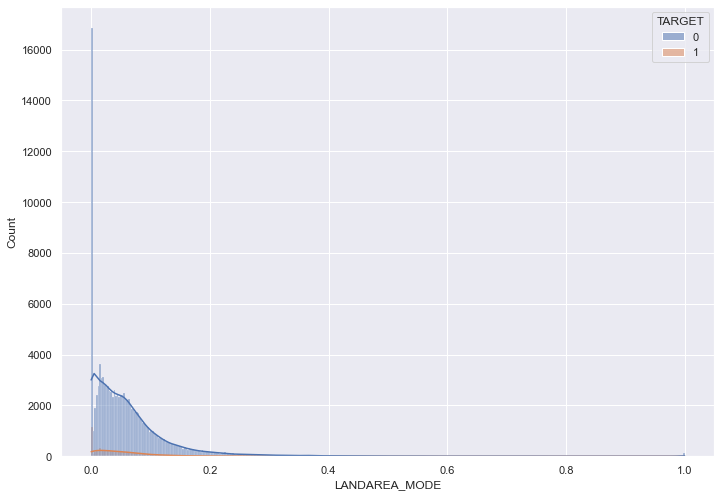

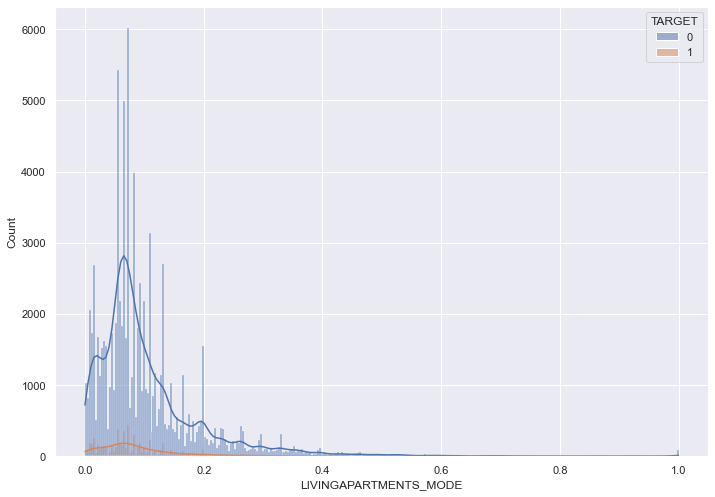

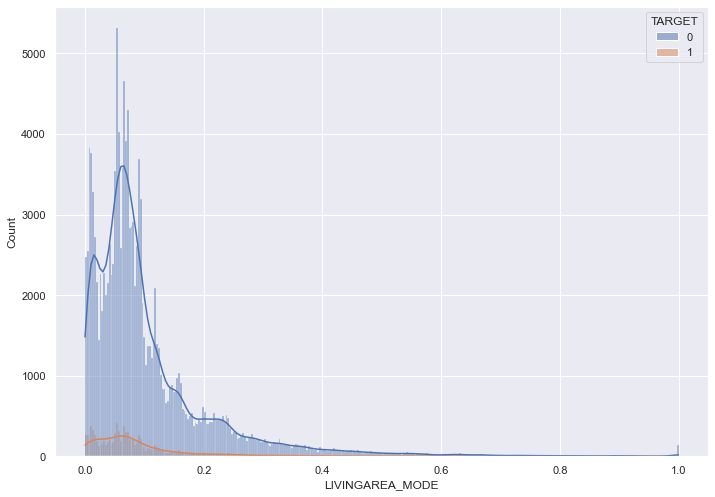

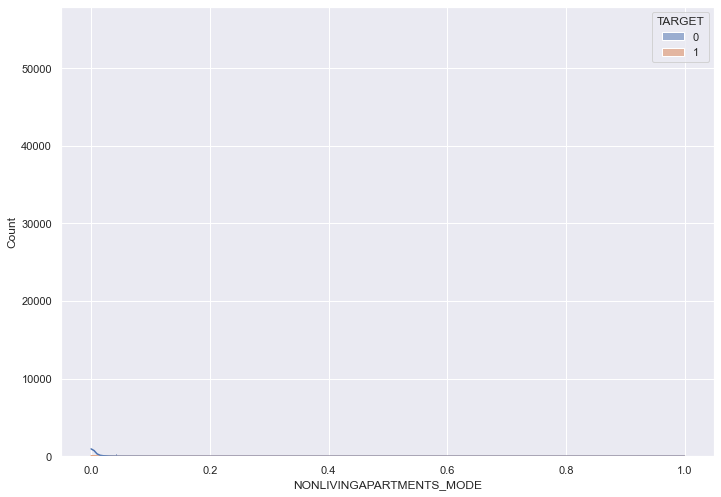

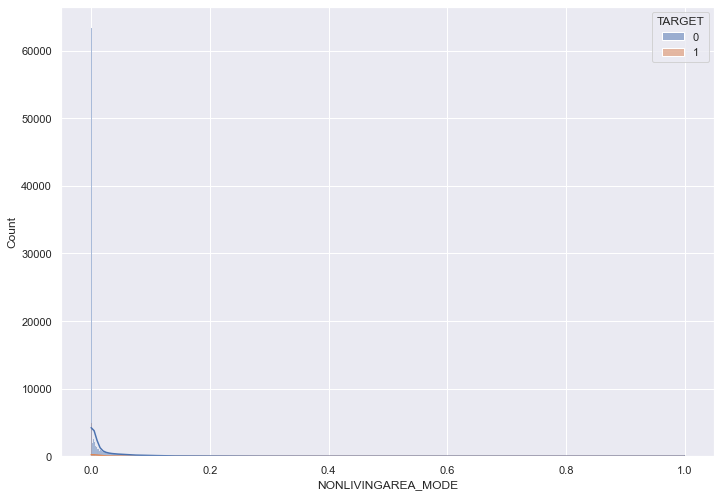

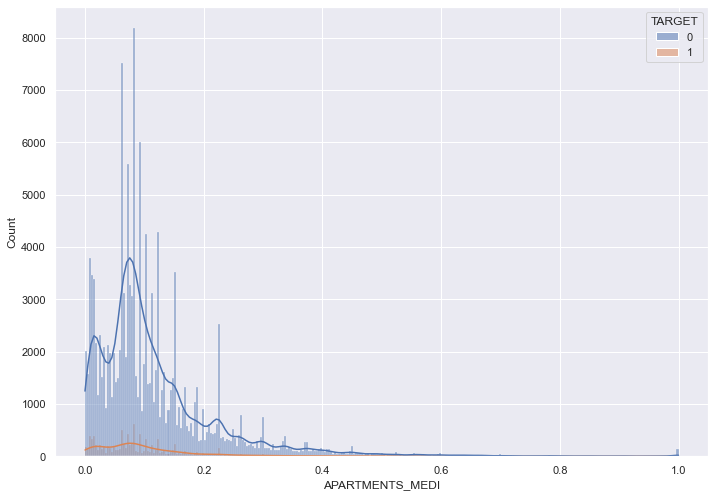

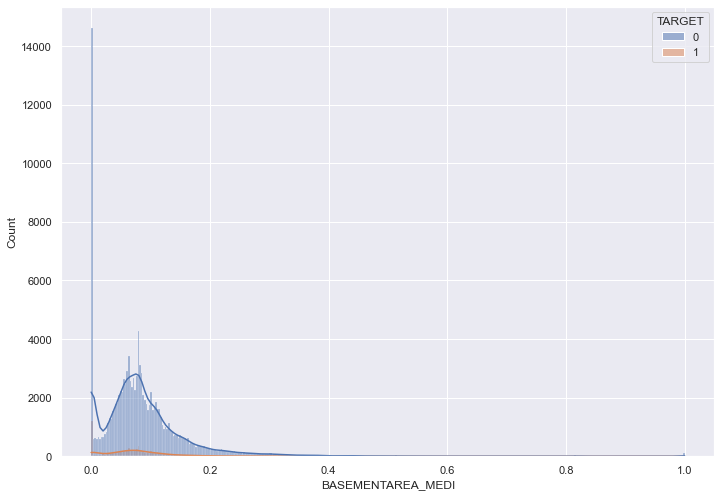

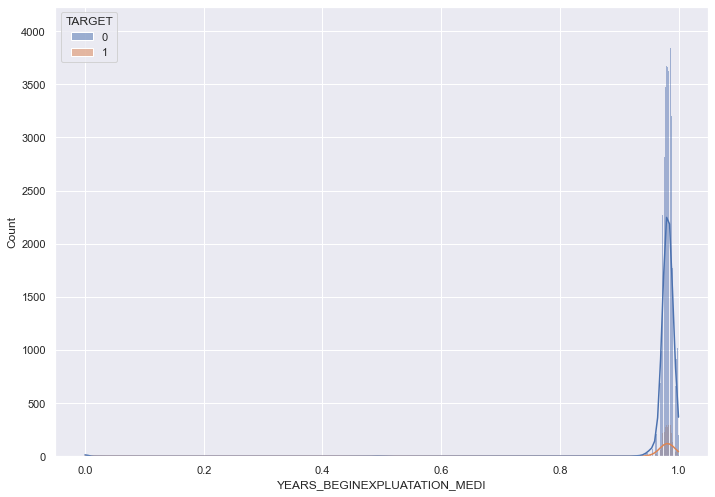

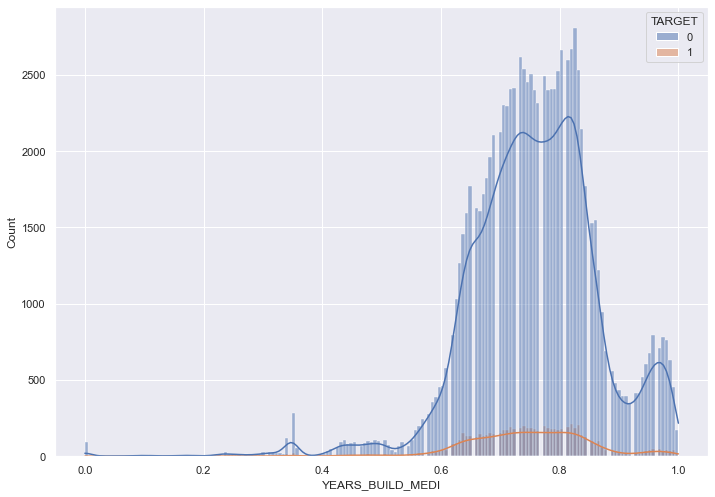

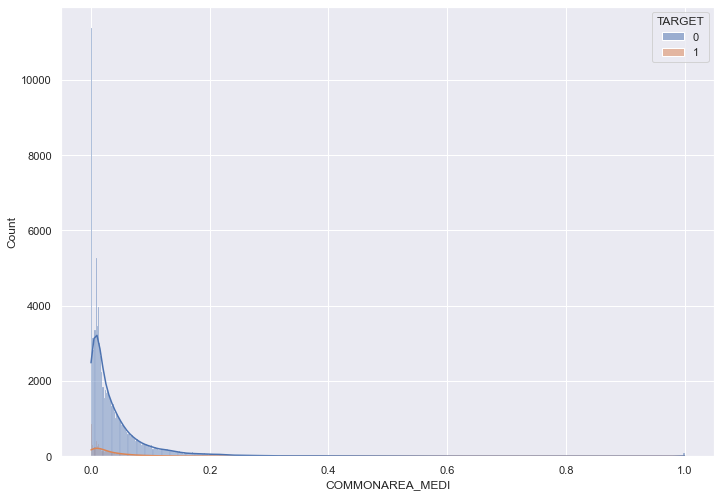

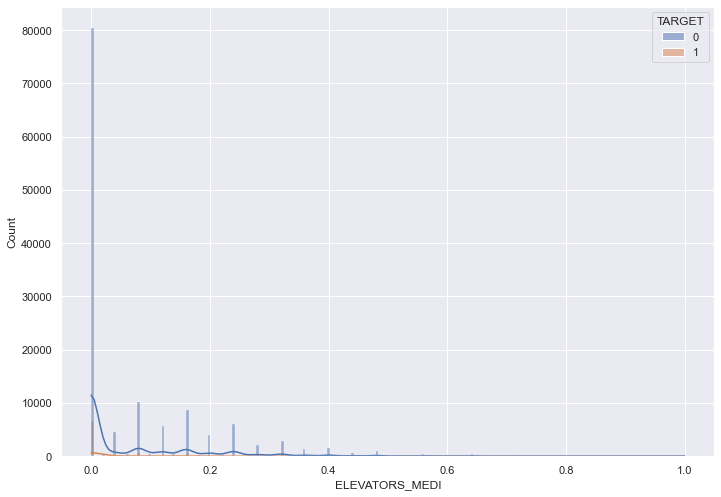

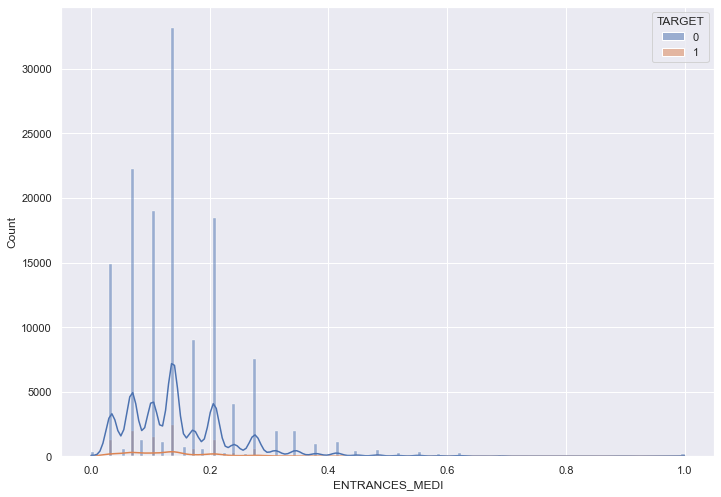

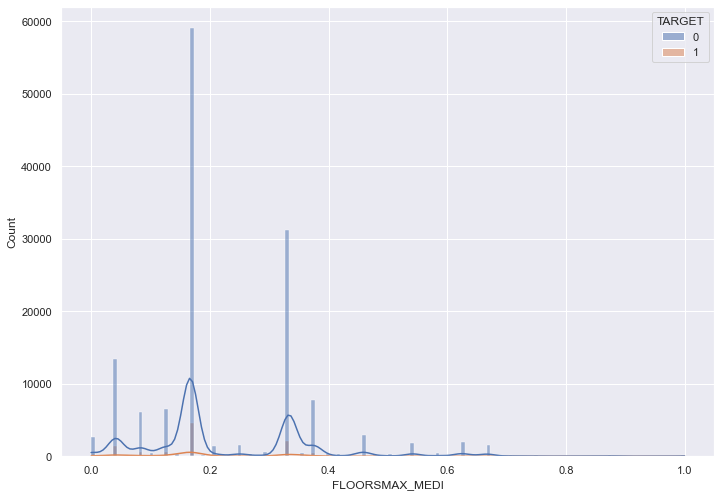

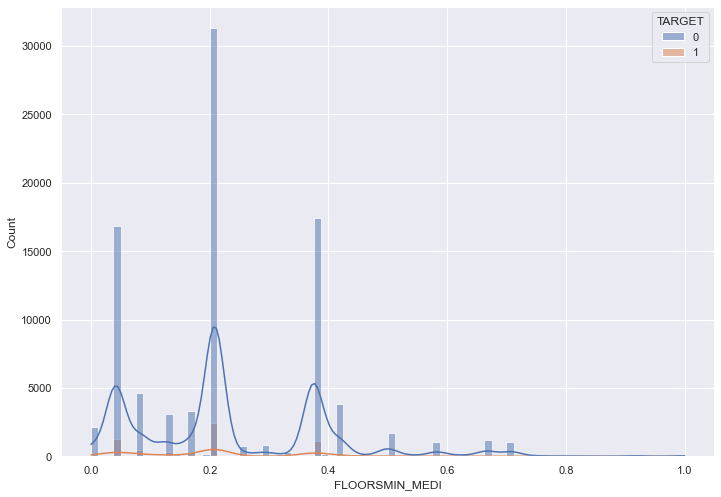

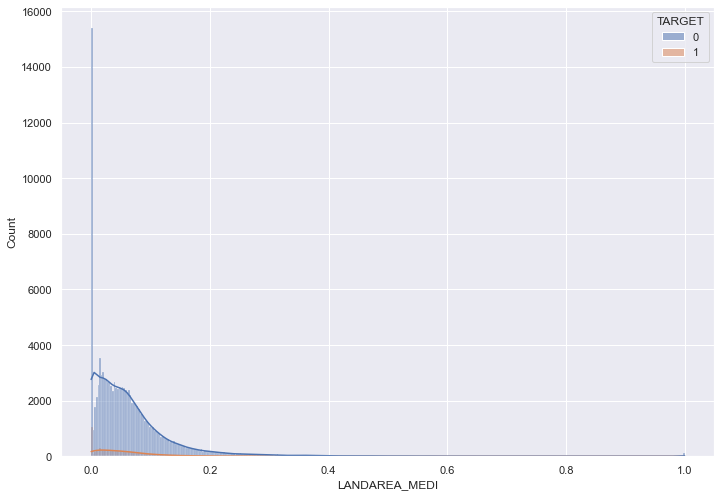

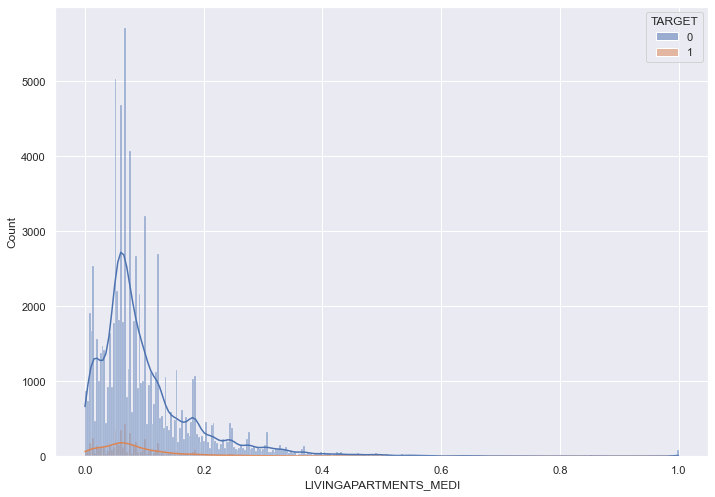

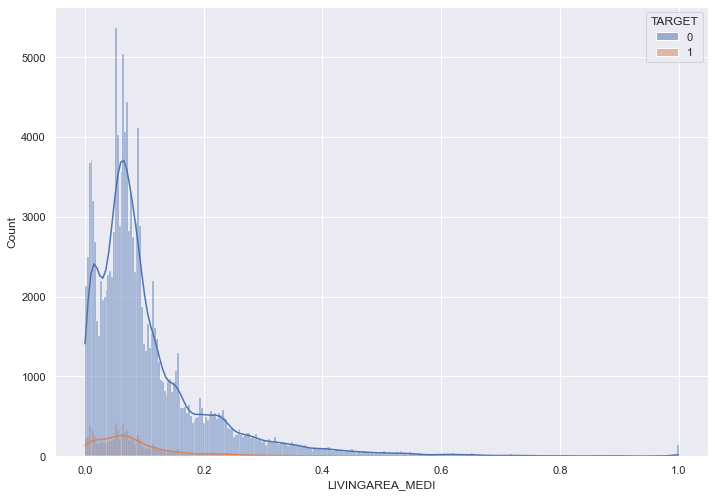

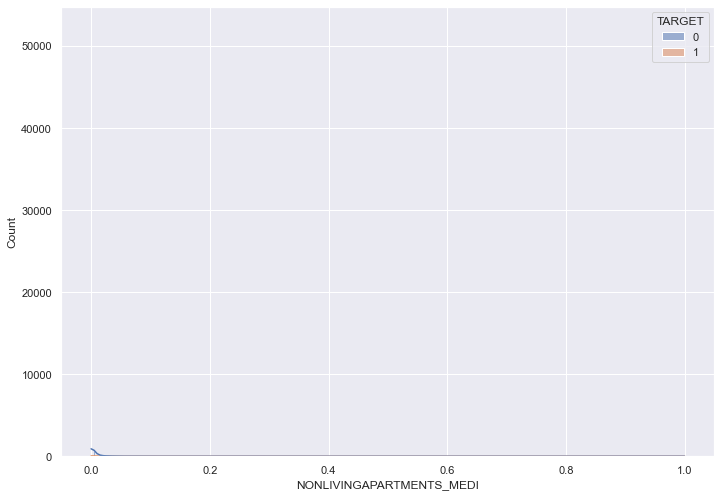

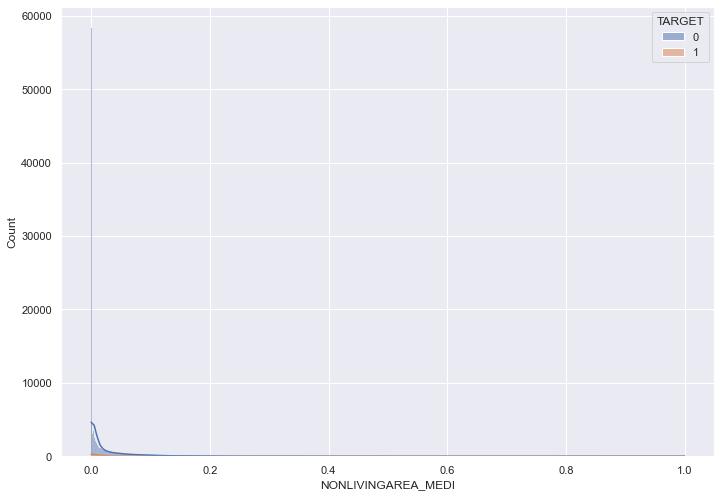

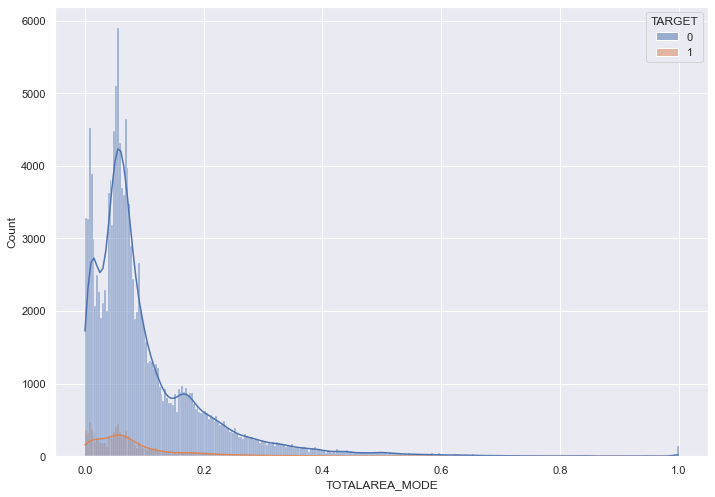

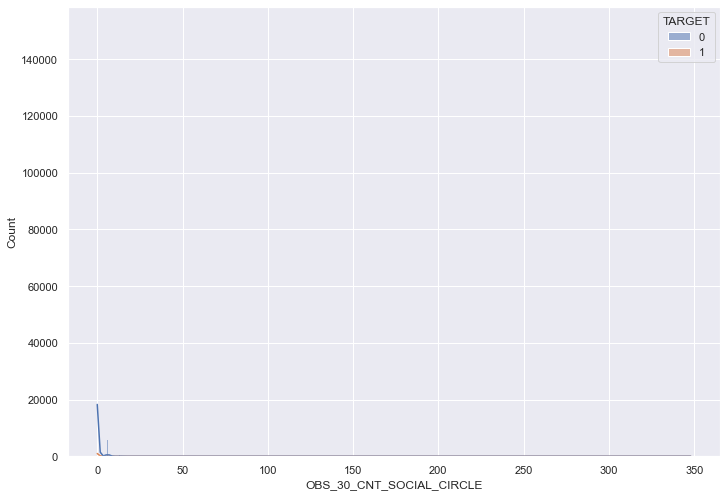

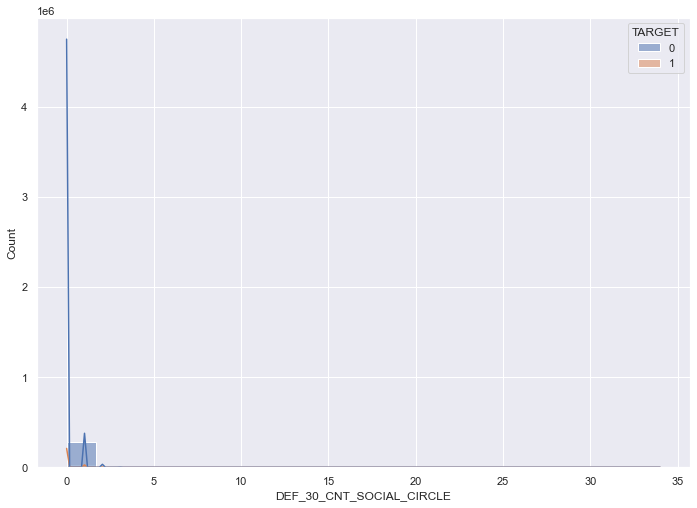

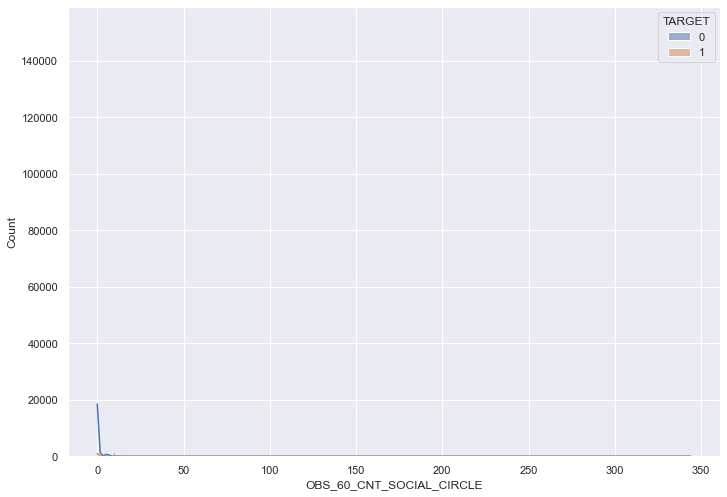

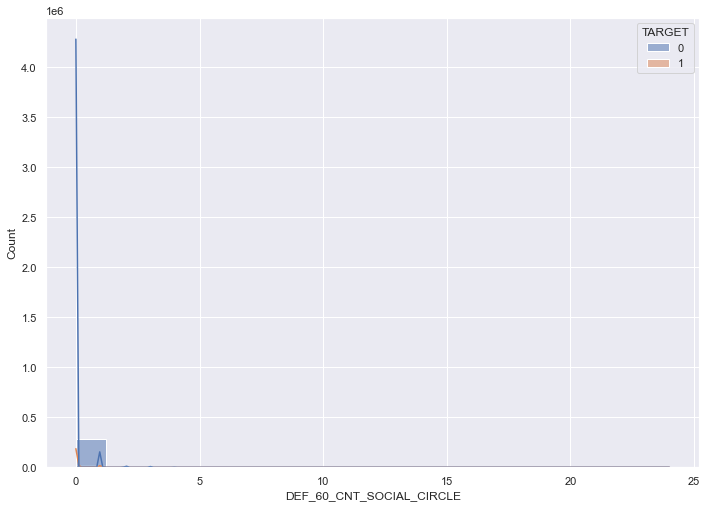

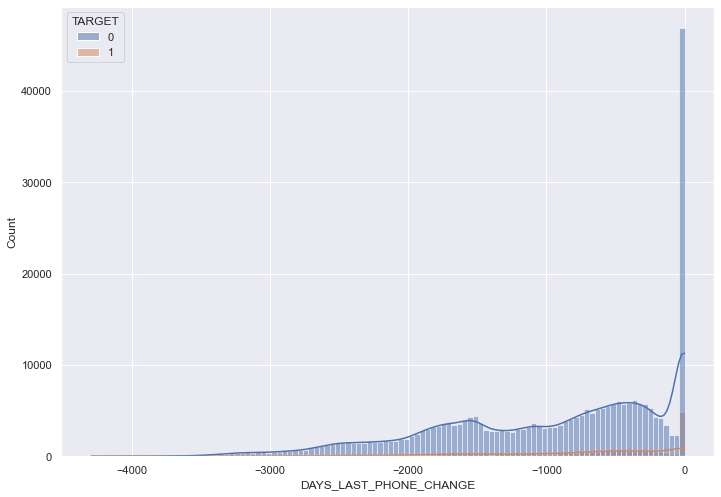

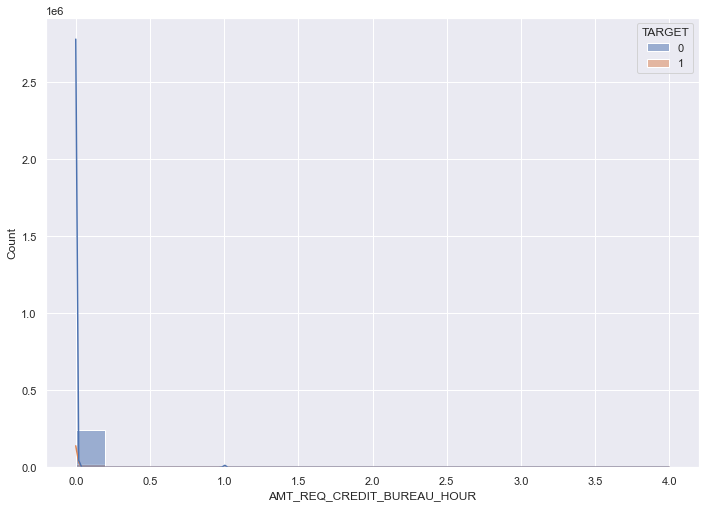

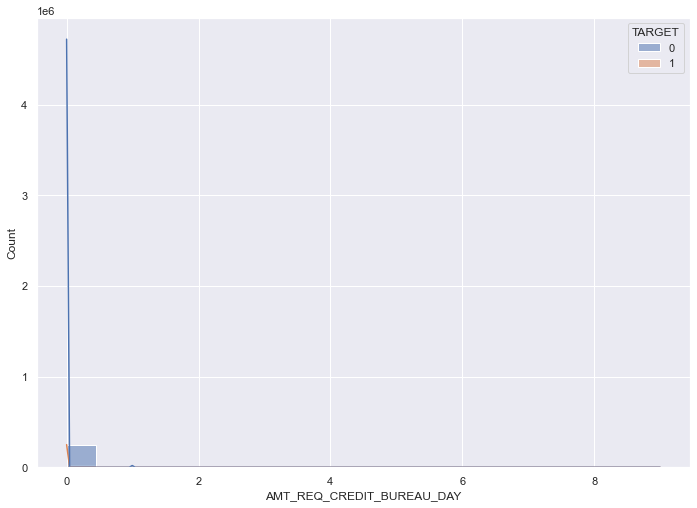

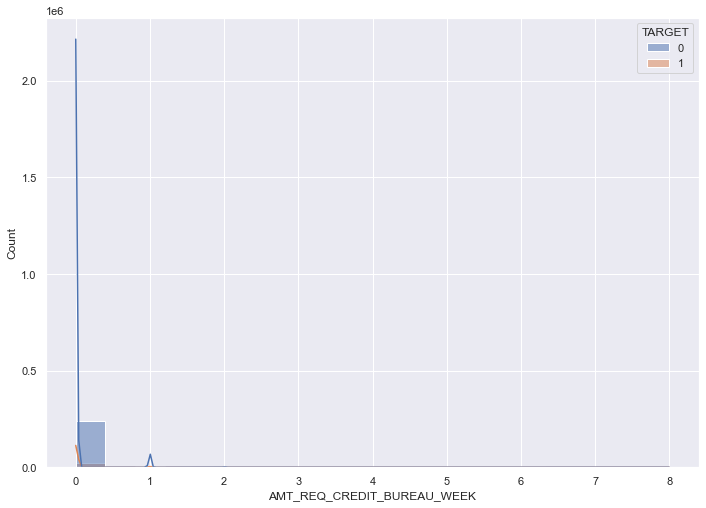

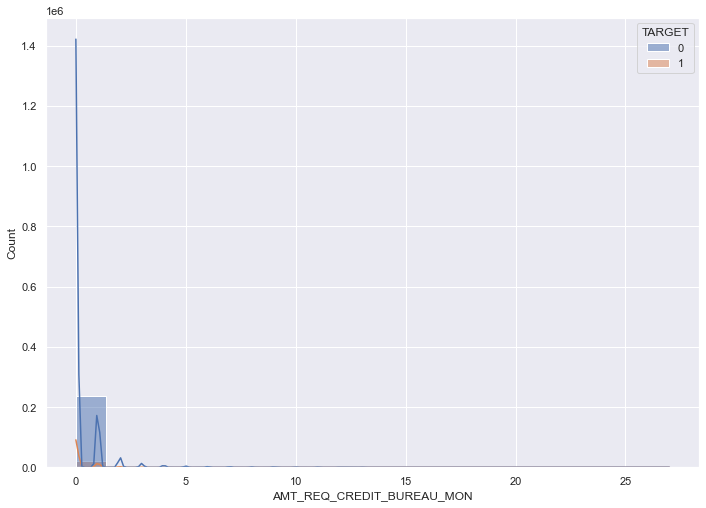

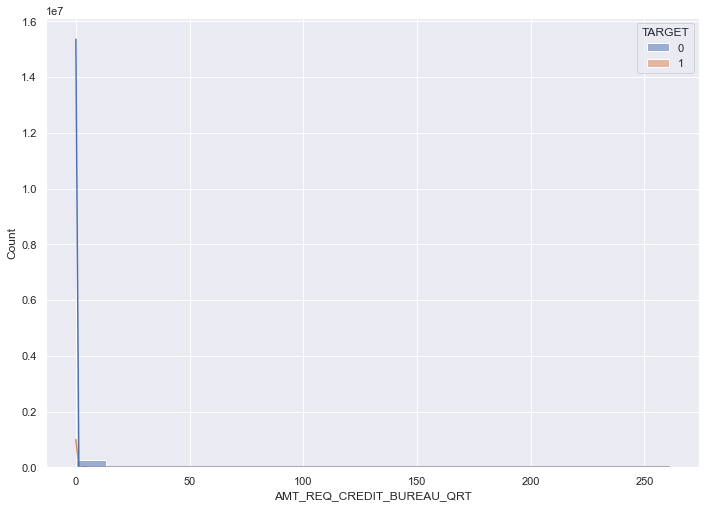

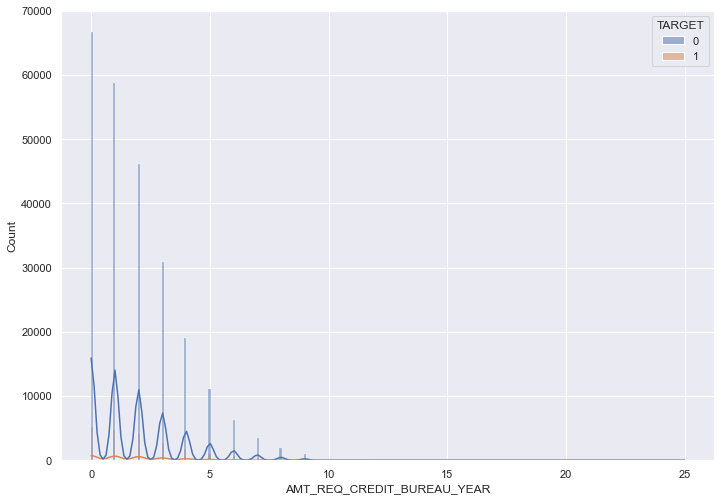

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
for col in application_train_numerical.columns:
    if col == 'TARGET':
        continue
    sns.histplot(data=application_train_numerical, x=col, hue='TARGET', kde=True)
    plt.show()

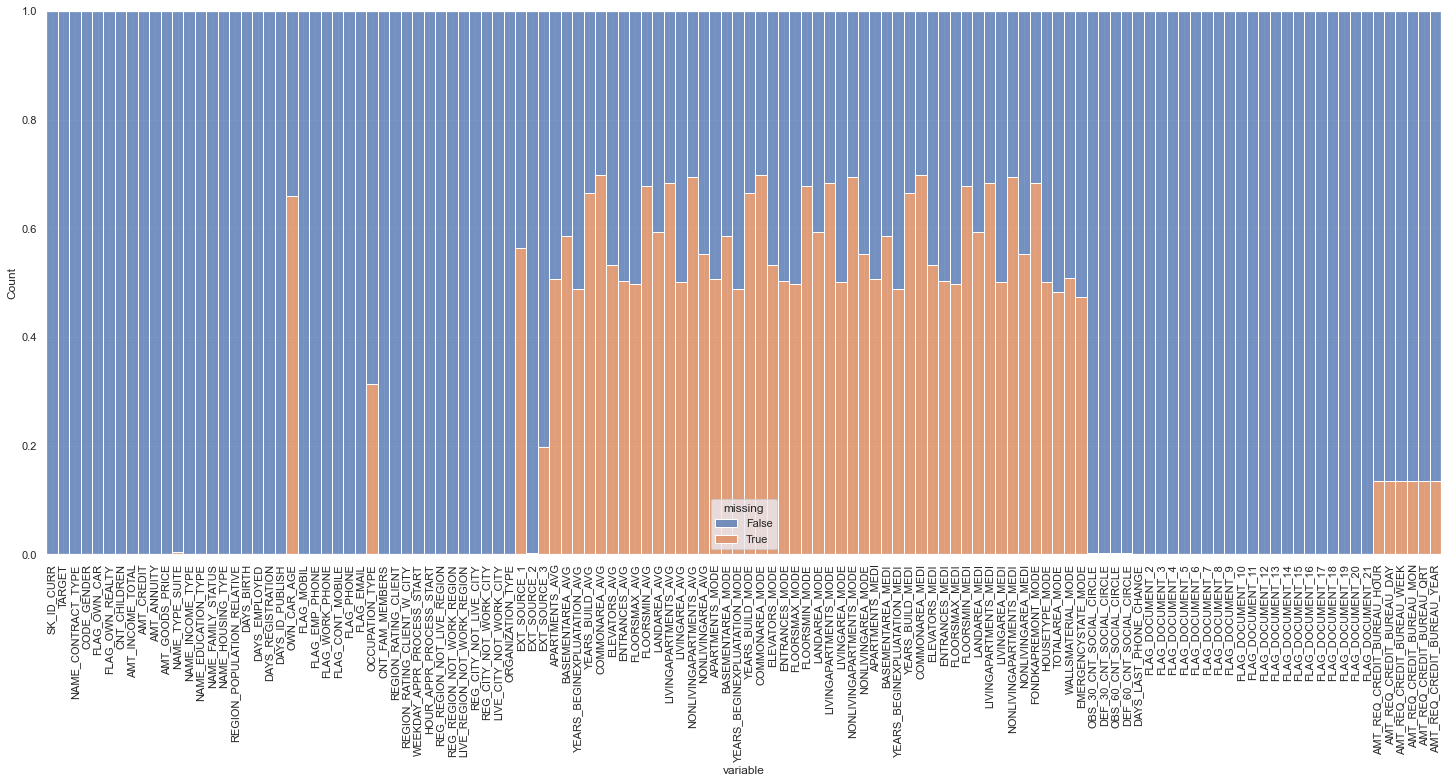

In [11]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.histplot(
    data=application_train.isna().melt(value_name='missing'),
    x='variable',
    hue='missing',
    multiple='fill',
    ax=ax
)
plt.xticks(rotation=90)
plt.show()

## Base Model (XGBoost)

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
import xgboost as xgb

C:\Users\ramez\.conda\envs\deeplearning\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [32]:
categorical_cols_not_target = [col for col in categorical_cols if col != 'TARGET']

In [33]:
len(categorical_cols_not_target)

50

#### One-Hot encoding of categorical variables

In [34]:
X = application_train.drop(columns=['TARGET','SK_ID_CURR'])

X_encoded = pd.get_dummies(X, columns=categorical_cols_not_target)

y = application_train['TARGET']

X_encoded.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 280 columns):
 #    Column                                             Non-Null Count   Dtype  
---   ------                                             --------------   -----  
 0    CNT_CHILDREN                                       307511 non-null  int64  
 1    AMT_INCOME_TOTAL                                   307511 non-null  float64
 2    AMT_CREDIT                                         307511 non-null  float64
 3    AMT_ANNUITY                                        307499 non-null  float64
 4    AMT_GOODS_PRICE                                    307233 non-null  float64
 5    REGION_POPULATION_RELATIVE                         307511 non-null  float64
 6    DAYS_BIRTH                                         307511 non-null  int64  
 7    DAYS_EMPLOYED                                      307511 non-null  int64  
 8    DAYS_REGISTRATION                                  307511 non-

#### Splitting the data into train and validation sets with stratified splitting

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
sum(y_train)/len(y_train)

0.08072908198107379

In [40]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    seed=42,
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=2.5,
    reg_lambda=1.2 
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=100,
    early_stopping_rounds=200,
    eval_metric='auc',
    eval_set=[(X_valid, y_valid)]
)

C:\Users\ramez\.conda\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ramez\.conda\envs\deeplearning\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.70380
[100]	validation_0-auc:0.73015
[200]	validation_0-auc:0.73437
[300]	validation_0-auc:0.74083
[400]	validation_0-auc:0.74643
[500]	validation_0-auc:0.75025
[600]	validation_0-auc:0.75297
[700]	validation_0-auc:0.75495
[800]	validation_0-auc:0.75637
[900]	validation_0-auc:0.75754
[1000]	validation_0-auc:0.75847
[1100]	validation_0-auc:0.75910
[1200]	validation_0-auc:0.75962
[1300]	validation_0-auc:0.76001
[1400]	validation_0-auc:0.76041
[1500]	validation_0-auc:0.76082
[1600]	validation_0-auc:0.76116
[1700]	validation_0-auc:0.76149
[1800]	validation_0-auc:0.76181
[1900]	validation_0-auc:0.76203
[2000]	validation_0-auc:0.76227
[2100]	validation_0-auc:0.76245
[2200]	validation_0-auc:0.76266
[2300]	validation_0-auc:0.76287
[2400]	validation_0-auc:0.76312
[2500]	validation_0-auc:0.76328
[2600]	validation_0-auc:0.76339
[2700]	validation_0-auc:0.76352
[2800]	validation_0-auc:0.76370
[2900]	validation_0-auc:0.76380
[3000]	validation_0-auc:0.76392
[3100]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1.2,
              scale_pos_weight=2.5, seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

C:\Users\ramez\.conda\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


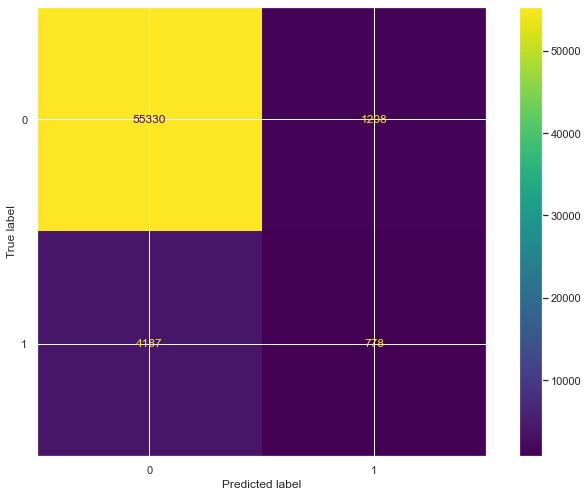

In [48]:
plot_confusion_matrix(xgb_clf, X_valid, y_valid)

In [54]:
feature_importances = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = xgb_clf.get_booster().feature_names
feature_importance_df['importance'] = feature_importances

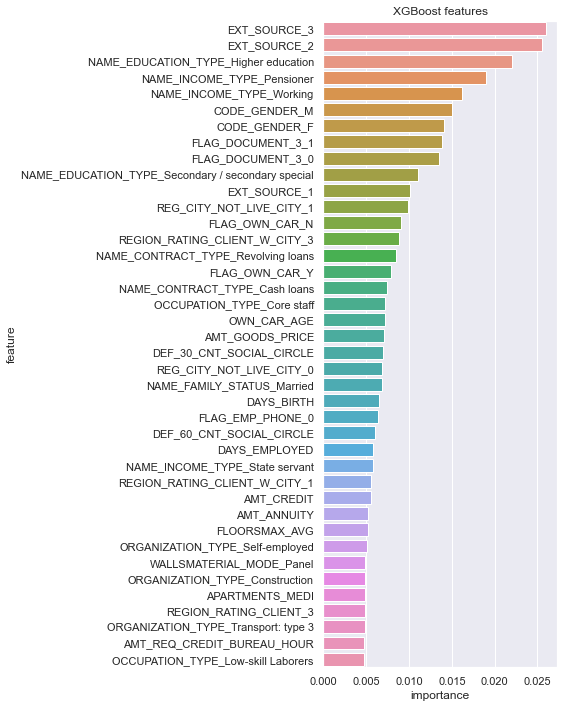

In [56]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGBoost features')
plt.tight_layout()